# Chest X-Ray Images (Pneumonia) Classification

### Introduction
By Ziv Ben Zvi 203966643 and Julian Rubinstein 204907901.

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.
Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

As mentioned above, a chest X-ray is a prominent and common way to identify pneumonia. Therefore, developing an accurate model for analyzing the results of a chest X-ray can be extremly helpful in succesfuly diagnosing pneumonia in patients. The following paper will discuss the development of such model and its subsuquent accuracy and efficacy in acomplishing this task. The learning proccess of this model uses the dataset provided in the kaggle competition [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion) and will attempt to classify X-ray lung images to either normal or pneumonia. The dataset contains 5,840 chest X-Ray RGB images (JPEG) divided into NORMAL or PNEUMONIA folders.

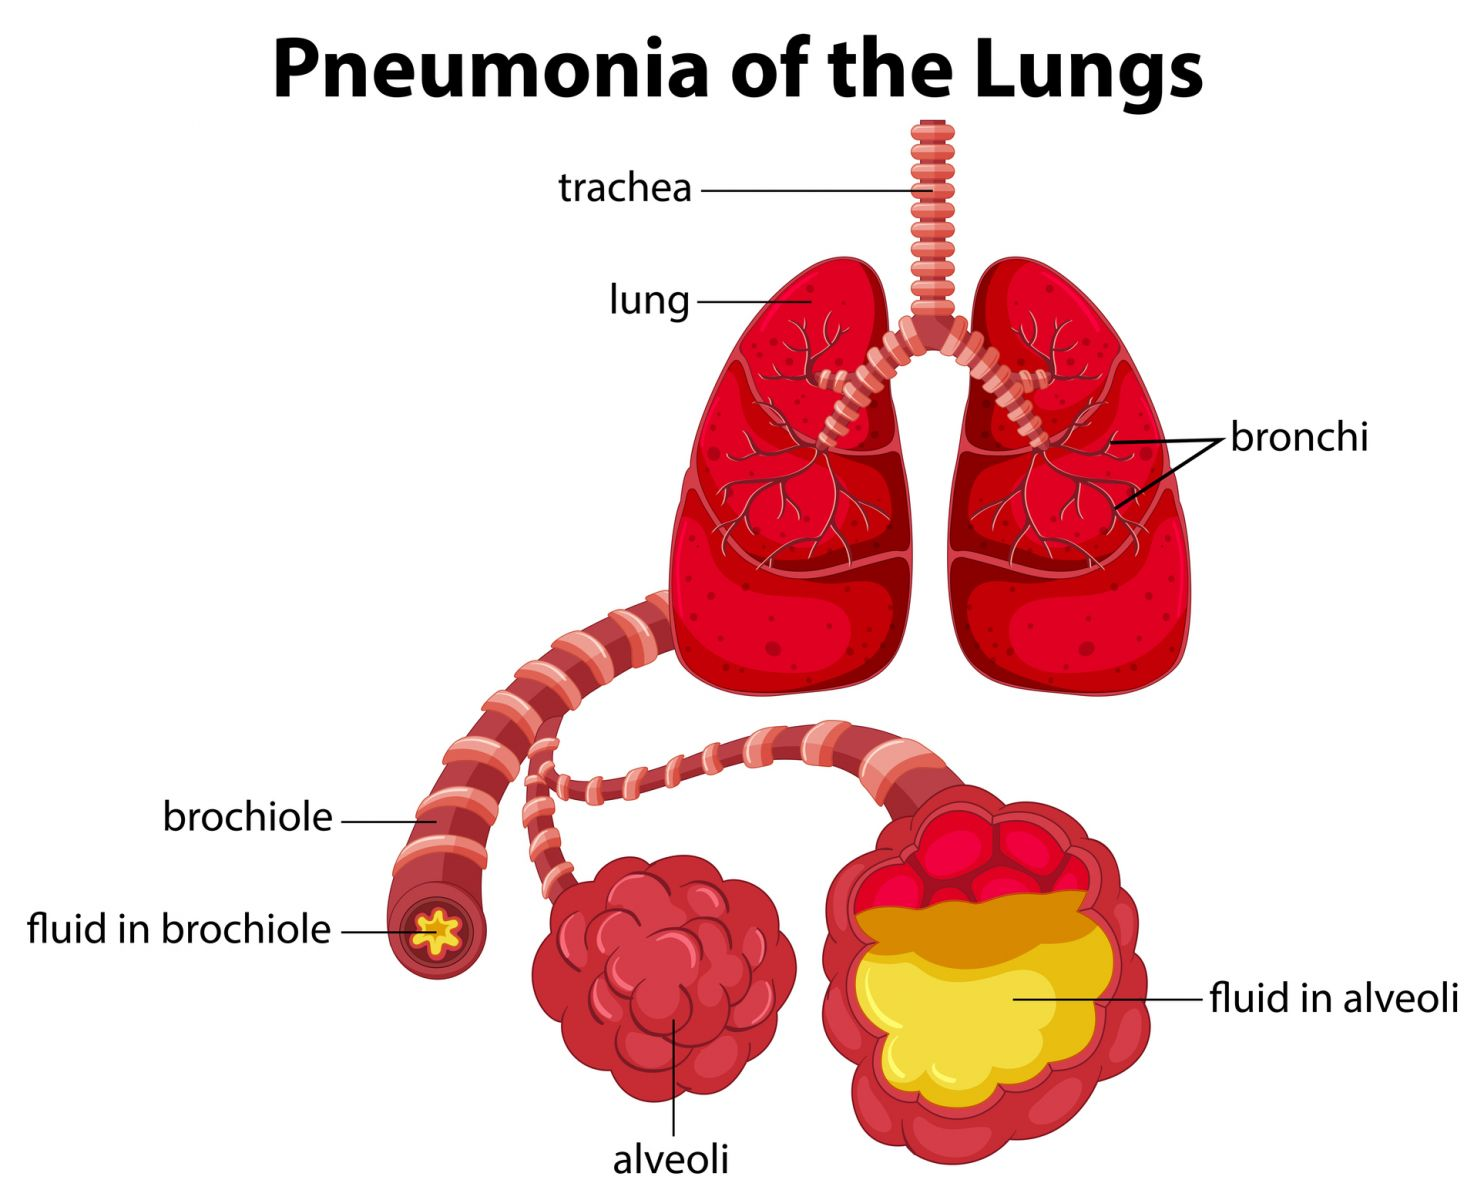

## Imports

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
import cv2

In [2]:
import sklearn
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import class_weight
import shap

## Loading Data and Data Processing

We define the data paths, compress the images by resizing them and then load the data to a list of 2d np arrays which represnt the images:

In [3]:
NORMAL_PATH = 'chest_xray/DATA/NORMAL'
PNEUMONIA_PATH = 'chest_xray/DATA/PNEUMONIA'

NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

normal_data = []
pneumonia_data = []

for file in tqdm(NORMAL_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    normal_data.append(image)

for file in tqdm(PNEUMONIA_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    pneumonia_data.append(image)

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4265 [00:00<?, ?it/s]

Let's print the size of both datasets and the shapes of the images:

In [4]:
print("Number of healthy patients images: " + str(len(normal_data)))
print("Number of sick patients images: " + str(len(pneumonia_data)))
print("Healthy image 1 shape: " + str(normal_data[0].shape))
print("Sick image 1 shape: " + str(pneumonia_data[0].shape))

Number of healthy patients images: 1575
Number of sick patients images: 4265
Healthy image 1 shape: (60, 100, 3)
Sick image 1 shape: (60, 100, 3)


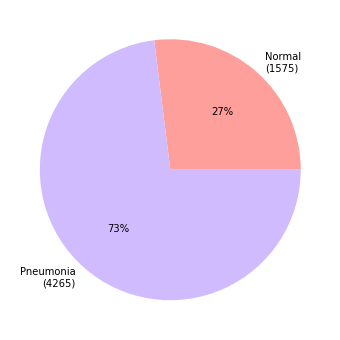

In [5]:
data = [len(normal_data), len(pneumonia_data)]
labels = [f'Normal\n({len(normal_data)})', f'Pneumonia\n({len(pneumonia_data)})']

plt.rcParams["figure.figsize"] = (10,6)
colors = sns.color_palette('pastel')[3:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()

Two things can be observed - Firstly, the shape of the images is 60X100X3, as expected following the compression done above and the fact the images are all RGB images. Secondly, we can see that the data contains approximatly 3 times the amount of sick images to healthy images, that is something that should be taken note of as it can affect the training of the model.

Next, in observing the images, it can be noticed that although the images are in RGB format, all the colors appear to be entirely greyscaled. In the following blocks of code we will check the possibility of converting the images to greyscale to both reduce the file-size of the images (which will make the model training faster) and to reduce the complexity of the images which will ease the process of image analysis.

Firstly, lets observe an image before and after converting it to greyscale format:

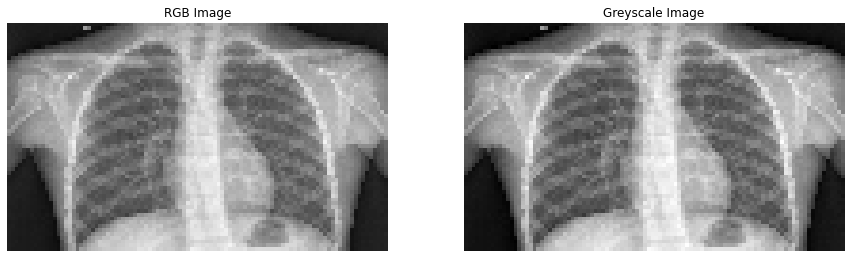

In [6]:
normal_image = normal_data[0]
gray_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2GRAY)
plt.rcParams["figure.figsize"] = (15,7)

fig, ax = plt.subplots(1,2)

ax[0].imshow(normal_image)
ax[0].set_title('RGB Image')
ax[0].axis('off')

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title('Greyscale Image')
ax[1].axis('off')

plt.show()

In [7]:
print("Before conversion shape: " + str(normal_data[0].shape))
print("After conversion shape: " + str(gray_image.shape))

Before conversion shape: (60, 100, 3)
After conversion shape: (60, 100)


As expected, it can be clearly seen that the conversion to grayscale hardly affects the visual of the image, if at all. Lets attempt to quantitevly show that the process of grayscaling does sacrifice the amount of information contained in the image.

Grayscale-like images are images in which all three RGB colors have similar values. For example - (0,0,0) would be black, (128,128,128) would be grey, and (255,255,255) would be white. On the other hand, (22,166,41) would be dark green. To prove that in approximation all images are grayscale-like, we would like to show that all image cells have approximatly the same value, i.e, low variance.

Lets calculate the standard deviation of every image in the data and calculate the average standard deviations of all images.

In [8]:
NUM_OF_PIXELS = 100*60

standard_deviations = []
sum = 0

for i in tqdm(range(len(normal_data))):
    for row in normal_data[i]:
            for cell in row:
                average = (int(cell[0]) + int(cell[1]) + int(cell[2])) / 3
                deviation = int(cell[0]) + int(cell[1]) + int(cell[2]) - 3 * average
                sum += deviation
            
    standard_deviations.append(sum/NUM_OF_PIXELS)

print("The average standard deviation of all images is: " + str(np.asarray(standard_deviations).mean()))

  0%|          | 0/1575 [00:00<?, ?it/s]

The average standard deviation of all images is: 0.0


As can be seen, all images are purely grayscale, as the standard deviation of all cells is preciesly zero. Therefore, we will proceed to convert all images to grayscale format:

In [9]:
normal_grayscale = []
pneumonia_grayscale = []

for index, image in tqdm(enumerate(normal_data)):
    normal_grayscale.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    
for index, image in tqdm(enumerate(pneumonia_data)):
    pneumonia_grayscale.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## EDA

Firstly, lets define a function to display images:

In [10]:
def plot_images(normal_img, pneumonia_img, plot_color):    
    fig, axis = plt.subplots(2,4)
    plt.rcParams["figure.figsize"] = (15,7)

    for index, image in enumerate(normal_img[:4]):
        axis[0,index].imshow(image, cmap=plot_color)
        axis[0,index].set_title('Normal')
        
    for index, image in enumerate(pneumonia_img[:4]):
        axis[1,index].imshow(image, cmap=plot_color)
        axis[1,index].set_title('Pneumonia')

    plt.show()

As a first step, lets simply observe a number of images of healthy patients and sick patients to see if we can point out any visual difference.

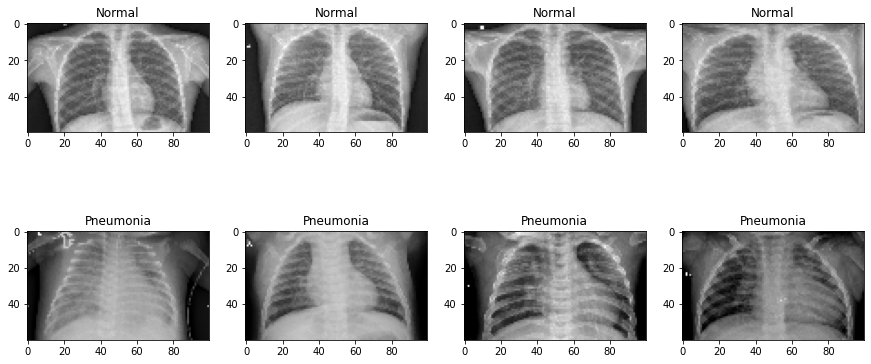

In [11]:
plot_images(normal_data, pneumonia_data, "gray")

By first examination, a slight difference of opacity within the ribcage can be noticed between the normal and the pneumonia-induced images. The pneumonia images appear to have a more cloudy color as opposed to the more transparent normal images (especially in the bottom left image that can be seen above).

Since these images are already converted to grey-scale, we can observe the single color distribution of the images and the mean pixel values:

<AxesSubplot:title={'center':'Pneumonia'}, ylabel='Count'>

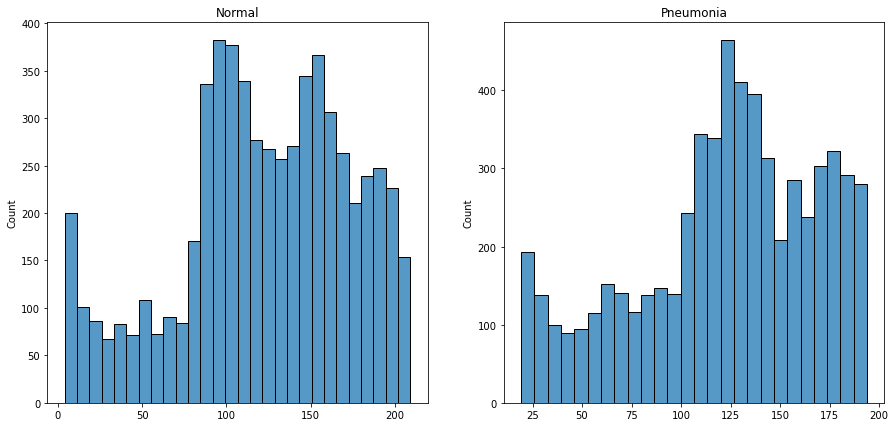

In [12]:
normal_dist = pneumonia_dist = 0
normal_flattened = []
pneumonia_flattened = []

for image in normal_grayscale:
    normal_flattened.append(image.flatten())

for image in normal_flattened:
    normal_dist += image/len(normal_grayscale)

for image in pneumonia_grayscale:
    pneumonia_flattened.append(image.flatten())

for image in pneumonia_flattened:
    pneumonia_dist += image/len(pneumonia_grayscale)

plt.rcParams["figure.figsize"] = (15,7)
plt.subplot(1, 2, 1)
plt.title('Normal')
sns.histplot(normal_dist)

plt.subplot(1, 2, 2)
plt.title('Pneumonia')
sns.histplot(pneumonia_dist)

A slight difference of shape between the distributions can be seen, however, nothing clear enough that can be pointed out without the use of more advanced tools. Lets observe the mean and median pixel values:

The mean pixel value of NORMAL images: 122
The mean pixel value of PNEUMONIA images: 122

The median pixel value of NORMAL images: 132
The median pixel value of PNEUMONIA images: 134

The standard deviation of the pixel value of NORMAL images: 62
The standard deviation of the pixel value of PNEUMONIA images: 59


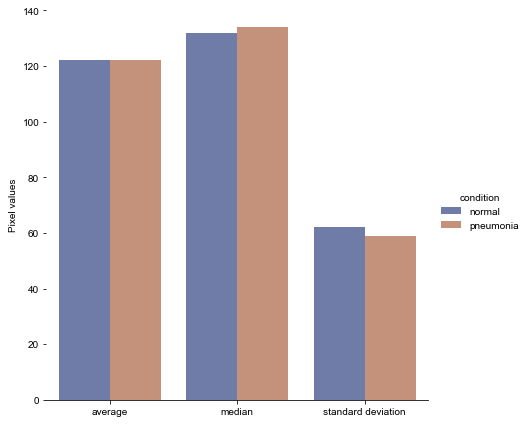

In [13]:
print(f"The mean pixel value of NORMAL images: {int(np.mean(normal_data))}")
print(f"The mean pixel value of PNEUMONIA images: {int(np.mean(pneumonia_data))}")

print(f"\nThe median pixel value of NORMAL images: {int(np.median(normal_data))}")
print(f"The median pixel value of PNEUMONIA images: {int(np.median(pneumonia_data))}")

print(f"\nThe standard deviation of the pixel value of NORMAL images: {int(np.std(normal_data))}")
print(f"The standard deviation of the pixel value of PNEUMONIA images: {int(np.std(pneumonia_data))}")\

normal_mean = int(np.mean(normal_grayscale))
pneumonia_mean = int(np.mean(pneumonia_grayscale))

normal_median = int(np.median(normal_grayscale))
pneumonia_median = int(np.median(pneumonia_grayscale))

normal_std = int(np.std(normal_grayscale))
pneumonia_std = int(np.std(pneumonia_grayscale))

df  = pd.DataFrame({"method" : ["average", "average", "median", "median", "standard deviation", "standard deviation"],
                "value" : [normal_mean, pneumonia_mean, normal_median, pneumonia_median, normal_std, pneumonia_std],
                "condition" : ["normal", "pneumonia", "normal", "pneumonia", "normal", "pneumonia"]},
                index = [1, 2, 3, 4, 5, 6])

plt.rcParams["figure.figsize"] = (15,7)
plot = sns.catplot(
    data=df, kind="bar",
    x="method", y="value", hue="condition",
    ci="None", palette="dark", alpha=.6, height=6
)
plot.despine(left=True)
plot.set_axis_labels("", "Pixel values")

sns.set(font_scale=1.15)


As can be clearly seen, the mean and median pixel values are extremly close and are well in the standard deviation of the pixel distribution. As such, this is not an avenue that will help the analysis.

We discovered that some images are in different form than the others. In some cases the images looks zoomed in:

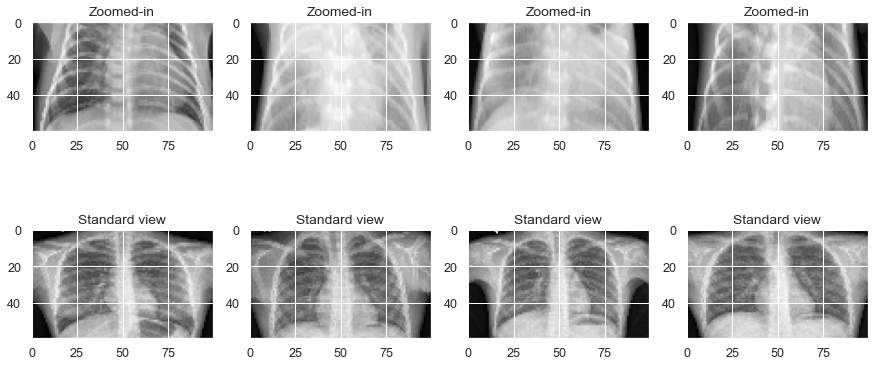

In [14]:
fig, axis = plt.subplots(2,4)
plt.rcParams["figure.figsize"] = (15,7)


axis[0,0].imshow(pneumonia_grayscale[2266], cmap="gray")
axis[0,1].imshow(pneumonia_grayscale[2284], cmap="gray")
axis[0,2].imshow(pneumonia_grayscale[2285], cmap="gray")
axis[0,3].imshow(pneumonia_grayscale[2286], cmap="gray")

axis[0,0].set_title('Zoomed-in')
axis[0,1].set_title('Zoomed-in')
axis[0,2].set_title('Zoomed-in')
axis[0,3].set_title('Zoomed-in')

        
for index, image in enumerate(normal_grayscale[10:14]):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Standard view')

plt.show()

Moreover, some images contain problematic data like medical devices and actual image data like the sign 'R' in the middle image who states which  is the right side of the figure. 

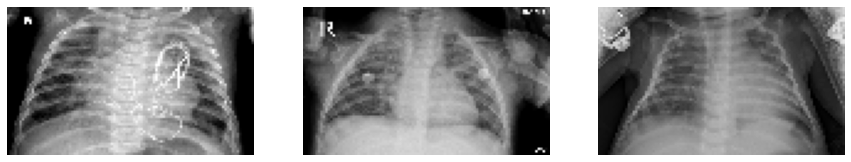

In [15]:
fig, axis = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (13,8)


axis[0].imshow(pneumonia_grayscale[402], cmap="gray")
axis[1].imshow(pneumonia_grayscale[593], cmap="gray")
axis[2].imshow(pneumonia_grayscale[2263], cmap="gray")

axis[0].axis("off")
axis[1].axis("off")
axis[2].axis("off")

plt.show()

Let's see what we can learn about the images by taking a closer look at their edges. We will use an algorithm for edge dection called Canny edge detector:

In [16]:
bad_images = []
zoomed_images = []
regular_images = []

bad_img_edges = []
zoomed_img_edges = []
regular_img_edges = []

bad_images.append(pneumonia_grayscale[402])
bad_images.append(pneumonia_grayscale[593])
bad_images.append(pneumonia_grayscale[2263])

zoomed_images.append(pneumonia_grayscale[2266])
zoomed_images.append(pneumonia_grayscale[2284])
zoomed_images.append(pneumonia_grayscale[2285])
zoomed_images.append(pneumonia_grayscale[2286])
 
for image in normal_grayscale[10:14]:
    regular_images.append(image)
    
for i in range(len(bad_images)):
    bad_img_edges.append(cv2.Canny(bad_images[i], 40, 100))

for j in range(len(zoomed_images)):
    zoomed_img_edges.append(cv2.Canny(zoomed_images[j], 40, 100))
    
for z in range(len(regular_images)):
    regular_img_edges.append(cv2.Canny(regular_images[z], 40, 100))

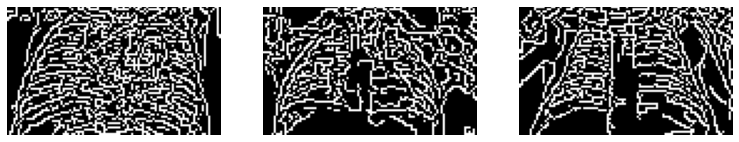

In [17]:
fig, axis = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (13,8)

axis[0].imshow(bad_img_edges[0], cmap="gray")
axis[1].imshow(bad_img_edges[1], cmap="gray")
axis[2].imshow(bad_img_edges[2], cmap="gray")

axis[0].axis("off")
axis[1].axis("off")
axis[2].axis("off")

plt.show()

By looking at the edges of the images with medical devices and data it doesn't look like we can observe any problem. We are hoping that when we will try to classify the images with different models, the models will be able to ignore the "bugs" in the images. Anyway, it seems there are very few images like those showen above and there is no way to locate all of them in our dataset. At the moment we will leave it but will keep that in mind.

Now let's view the zoomed-in images compared to the standard images with respect to their edges:

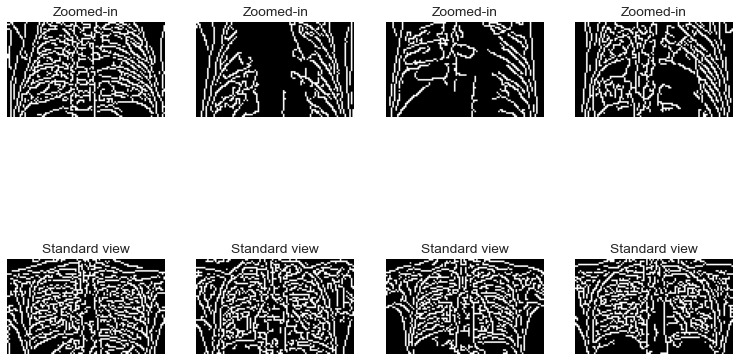

In [18]:
fig, axis = plt.subplots(2,4)
plt.rcParams["figure.figsize"] = (15,7)

axis[0,0].imshow(zoomed_img_edges[0], cmap="gray")
axis[0,1].imshow(zoomed_img_edges[1], cmap="gray")
axis[0,2].imshow(zoomed_img_edges[2], cmap="gray")
axis[0,3].imshow(zoomed_img_edges[3], cmap="gray")

axis[0,0].axis("off")
axis[0,1].axis("off")
axis[0,2].axis("off")
axis[0,3].axis("off")

axis[0,0].set_title('Zoomed-in')
axis[0,1].set_title('Zoomed-in')
axis[0,2].set_title('Zoomed-in')
axis[0,3].set_title('Zoomed-in')

        
for index, image in enumerate(regular_img_edges):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Standard view')
    axis[1,index].axis("off")

plt.show()

Okay, clearly now we see the differences of the complete figure compared to the zoomed-in figure.
As before, this type of zoomed-in images are very few among our dataset, and it's hard to locate them. further more, it does'nt sound reasonable to zoom in all standard images just to balance the data, especcialy when majority of the images are of regular view.
We will leave it for now, and check for Data Transformations and Augmentation solution later when training classification models.

##### ORB - edge detection method
ORB stands for Oriented FAST and Rotated BRIEF, which are two algorithms used for feature extraction from an image. For our needs we will focus on the FAST method of The ORB algorithm, which means edge detection in an image. Our definition of an edge is as follow:<br>
Given a pixel p of a 2D image, the algorithm compares the value of p to his surrounding 16 pixels that are in a circle around him. The pixel's value stands for brightness. The pixels surrounding p is then sorted into three categories:
- Lighter than p
- Darker than p 
- Similar to p

In case of more than 8 pixels are brighter or darker than p, the pixel p is selected as a keypoint. Keypoints calculated by ORB algorithm gives us information of the location of determining edges in an image.<br>For our use, we would like to compare the amount of keypoints founded by ORB in normal and pneumonia images. Many keypoints will stand for high contrast between neighbour pixels in an image, where few keypoints will present low contrast between neighbour pixels.

Let's set our ORB algorithm

In [19]:
orb = cv2.ORB_create(edgeThreshold=15,
                     patchSize=31,
                     nlevels=8,
                     fastThreshold=20,
                     scaleFactor=1.2,
                     WTA_K=2,
                     scoreType=cv2.ORB_HARRIS_SCORE,
                     firstLevel=0,
                     nfeatures=250)

In [20]:
normal_orb_data = []
pneumonia_orb_data = []

for image in normal_grayscale:
    normal_orb_data.append(image)
    
for image in pneumonia_grayscale:
    pneumonia_orb_data.append(image)

After copying our data to a different array in order to leave the original data unchanged, we will run the algorithm with our copied images and plot the pixels values

In [21]:
normal_orb_keypoints = []
pneumonia_orb_keypoints = []

for image in normal_orb_data:
    keypoint, desc = orb.detectAndCompute(image,None)
    normal_orb_keypoints.append(len(keypoint))
    
for image in pneumonia_orb_data:
    keypoint, desc = orb.detectAndCompute(image,None)
    pneumonia_orb_keypoints.append(len(keypoint))

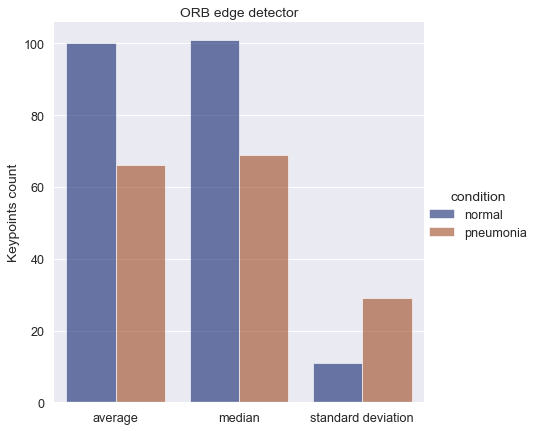

In [22]:
normal_mean = int(np.mean(normal_orb_keypoints))
pneumonia_mean = int(np.mean(pneumonia_orb_keypoints))

normal_median = int(np.median(normal_orb_keypoints))
pneumonia_median = int(np.median(pneumonia_orb_keypoints))

normal_std = int(np.std(normal_orb_keypoints))
pneumonia_std = int(np.std(pneumonia_orb_keypoints))
    
df  = pd.DataFrame({"method" : ["average", "average", "median", "median", "standard deviation", "standard deviation"],
                    "value" : [normal_mean, pneumonia_mean, normal_median, pneumonia_median, normal_std, pneumonia_std],
                    "condition" : ["normal", "pneumonia", "normal", "pneumonia", "normal", "pneumonia"]},
                    index = [1, 2, 3, 4, 5, 6])

plt.rcParams["figure.figsize"] = (15,7)
plot = sns.catplot(
        data=df, kind="bar",
        x="method", y="value", hue="condition", 
        ci="None", palette="dark", alpha=.6, height=6
    )
plot.despine(left=True)
plot.set_axis_labels("", "Keypoints count")
plt.title("ORB edge detector")    
sns.set(font_scale=1.15)

As seen the normal images seems to have a more contrast between neighbour pixels, which means we are more likely to see dark and bright parts in a given normal image, while on pneumonia images we will probably observe monotonous brightness level.

## PCA

We want to further explore the main difference between the normal and sick images. PCA is an effective method used to detect the main components of an image and through it to reduce the dimensionality of the dataset.

We will start by defining our pca model and compiling it on our combined dataset of images of both the pneumonia and normal images: 

In [23]:
combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_flattened + pneumonia_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

PC1        PC2        PC3        PC4        PC5        PC6
0 -11.739896  20.709378  33.057153  -3.488386  10.704985  36.685987
1 -47.465511 -12.719462  17.865603   4.914049 -12.637897  10.982406
2 -22.774161  23.508687  37.292033   9.330579  13.611383  19.674552
3 -35.245922  54.317781  30.141207  14.385774 -13.055608   0.499483
4 -25.918642  27.331506  38.633682  20.172759  14.768972  12.064389

We can see that the first PC contains about a third of the variance in the images while the first three combined hold almost half of all the variance between the images. Therefore we will only analyze the first 3 PCs. We will now proceed to divide the images based on their PC scores and see if any of them will show a pattern of normal/pneumonia images or have any visible properties which can help to analyze the images. All PCs will be shown with the first 2 rows of images corresponding to the higest score and the second 2 rows will correspond to the low pc score.

explained variance ratio (first three components): [0.29068861 0.09298998 0.06840393]
sum of first three components: 0.452083


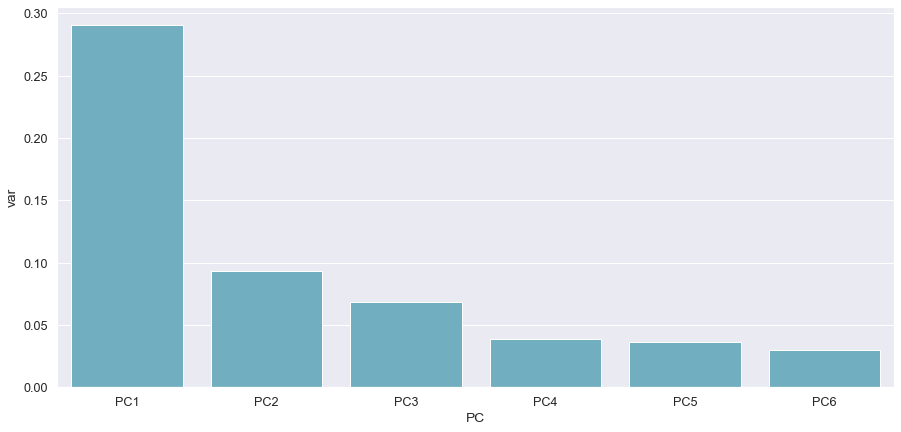

In [24]:
pca.explained_variance_ratio_

df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

print('explained variance ratio (first three components): %s' % str(pca.explained_variance_ratio_[:3]))
print('sum of first three components: %f' % float(np.sum(pca.explained_variance_ratio_[:3])))

Lets define a function to display the pca images as described above:

In [25]:
def plot_pca_images(pca_num, normal_data, pneumonia_data):
    highest_score_ids = np.argpartition(combined_reduced[:, pca_num], -8)[-8:]
    lowest_score_ids = np.argpartition(combined_reduced[:, pca_num], 8)[:8]

    combined_images = normal_data + pneumonia_data
    labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
    
    plt.figure(figsize=(15,10))
    for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
        img = combined_images[ids]
        plt.subplot(4,4,num+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray")
        plt.title(f"{labels[ids]}",fontsize=18)

#### First PC

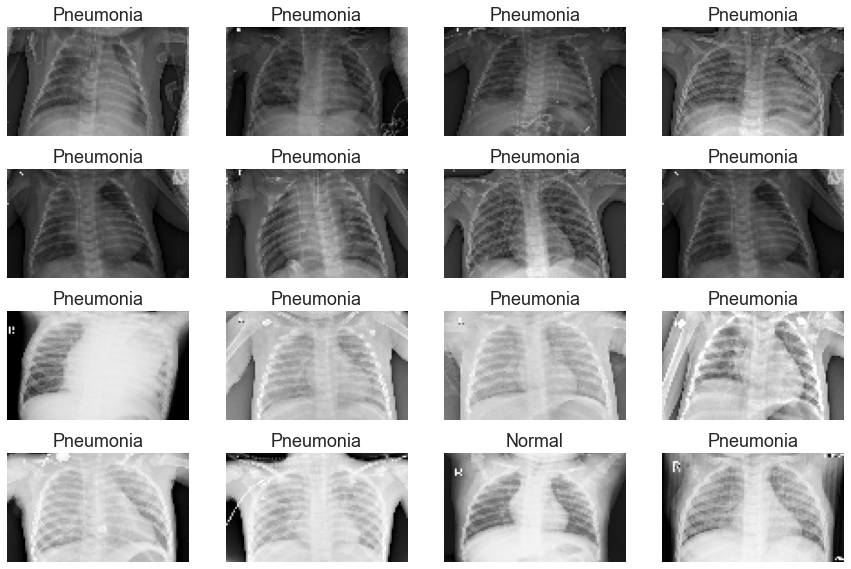

In [26]:
plot_pca_images(0, normal_grayscale, pneumonia_grayscale)

It can be clearly seen that the first PC is that of the total brightness of the images (the mean value of the pixels of the images). It can be noticed that both the first two rows (lowest score) and the last two rows (highest score) are both entirely made of pneumonia images, as such, this PC does not help our classification. However, this is a major PC that be accounted for by normalizing all the images according to their average pixel value. This could potentially help the model classify images.

#### Second PC

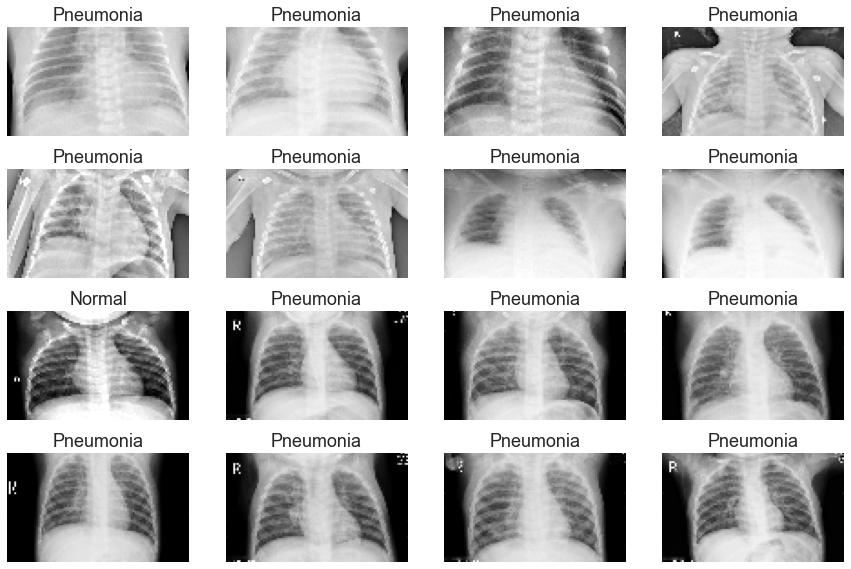

In [27]:
plot_pca_images(1, normal_grayscale, pneumonia_grayscale)

It can be seen that this PC corresponds to the amount of background that exists in the image. Similar to the first PC, this PC doesn't help us very much for classifying as all rows are consisted of entirely pneumonia images. We can normalize with regards to this PC as well, however, in contrast to the first PC, this PC accounts for a much smaller part of the variance and as such the 'return on investment' for normalizing in respect to it will be low.

#### Third PC

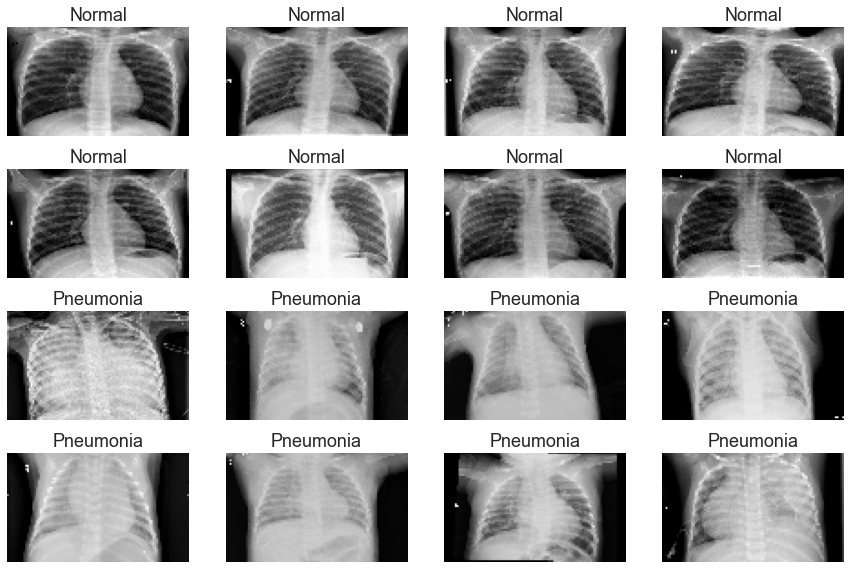

In [28]:
plot_pca_images(2, normal_grayscale, pneumonia_grayscale)

Jackpot! This PC has managed to completly divide between the pneumonia images and the normal images with an accuracy of 100% for 16 images.  In quick observation, it seems as this PC is the relative opacity of the ribcage. It can be seen that in the pneumonia images the ribcages are 'cloudy' and are of similar pixel value to the boundaries, whilst at the normal images the ribcages have a darker color and the boundaries are sharper and clearer to see. We will now attempt to use this PCA as a classfication tool for lung images.

The way this will be done will be by arranging the data in an array from the highest PC score to the lowest PC score. We will then divide the array to two arrays according to the relative size of the data. Every normal image in the first array will be counted and divided by the length of the array. Thats the accuracy for the normal image prediction. The same will be done for pneumonia images and the second array. The total accuracy will be the weighted average of both accuracies.

##### Testing the pca  

In [29]:
NORMAL_LENGTH = len(normal_data)
PNEUMONIA_LENGTH = len(pneumonia_data)

labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)

predicted_as_normal = np.argpartition(combined_reduced[:, 2], -NORMAL_LENGTH)[-NORMAL_LENGTH:]
predicted_as_pneumonia = np.argpartition(combined_reduced[:, 2], PNEUMONIA_LENGTH)[:PNEUMONIA_LENGTH]

normal_count = 0
pneumonia_count = 0

for image in predicted_as_pneumonia:
    if labels[image] == "Pneumonia":
        pneumonia_count += 1

for image in predicted_as_normal:
    if labels[image] == "Normal":
        normal_count += 1

pneumonia_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
normal_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
total_accuracy = int((pneumonia_group_accuracy * PNEUMONIA_LENGTH + normal_group_accuracy * NORMAL_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))

print(f"The pneumonia group contains: {pneumonia_group_accuracy} % pneumonia images")
print(f"The normal group contains: {normal_group_accuracy} % normal images")
print(f"The total accuracy is: {total_accuracy} % \n")


The pneumonia group contains: 86 % pneumonia images
The normal group contains: 63 % normal images
The total accuracy is: 79 % 



The total accuracy of our third PC is quite impressive. We managed to find a classifying tool, without any complex models, that performs with accuracy of 79%. 

Lets visualize the distrubution of images with respect to first (highest variance) and third (relevant) PCs:

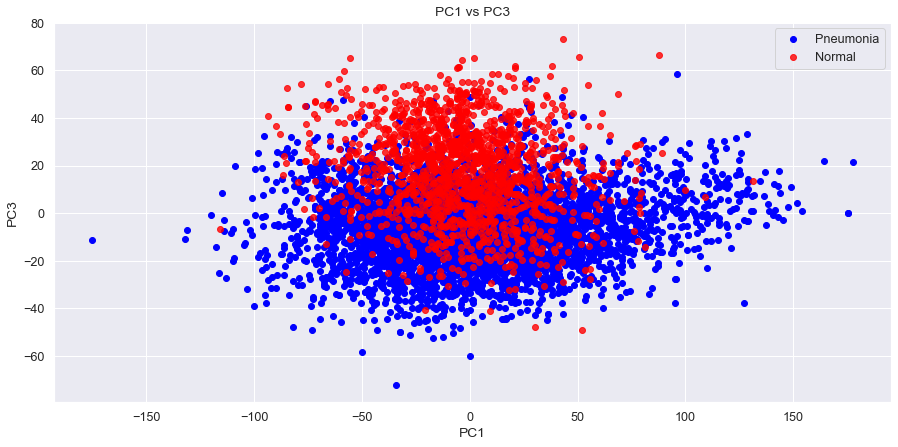

In [30]:
columns = ['PC' + str(i) for i in range(1,7)]
pca_df = pd.DataFrame(data=combined_reduced , columns=columns)

plt.scatter(pca_df.PC1[1575:], pca_df.PC3[1575:], c='blue')
plt.scatter(pca_df.PC1[:1575], pca_df.PC3[:1575], c='red', alpha=0.8)

plt.legend(['Pneumonia', 'Normal'])

plt.title('PC1 vs PC3')
plt.xlabel('PC1')
plt.ylabel('PC3')

plt.show()

This is good. We can clearly see a seperation between the images along the PC3 axis. Lets continue our analysis and see if we can improve upon this by normalizing with respect to the first PC.

#### Normalizing the first PC

In order to account for the first PCA and to reduce the interference of irelevant image properties, we will normalize all the images with respect to their mean pixel value and re-attempt the pca analysis. 

In [31]:
normal_normalized = []
pneumonia_normalized = []

normal_normalized_flattened = []
pneumonia_normalized_flattened = []

for index, image in enumerate(normal_grayscale):
    normal_normalized.append(image / np.mean(image))

for index, image in enumerate(pneumonia_grayscale):
    pneumonia_normalized.append(image / np.mean(image))

for index, image in enumerate(normal_flattened):
    normal_normalized_flattened.append(image / np.mean(image))

for index, image in enumerate(pneumonia_flattened):
    pneumonia_normalized_flattened.append(image / np.mean(image))

In [32]:
combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_normalized_flattened + pneumonia_normalized_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

PC1        PC2        PC3        PC4        PC5        PC6
0 -34.252956 -22.605889  17.331139   1.065027  -5.070141  45.246718
1 -14.090140 -27.830852 -15.620046  -3.522651  -3.236097   0.810786
2 -40.341136 -23.792983  18.041043  14.760928   6.122379  32.263848
3 -67.440044  -7.342272  14.820161   6.772991  30.479050  22.666431
4 -45.306657 -23.287056  15.237730  23.542275   9.610401  25.430086

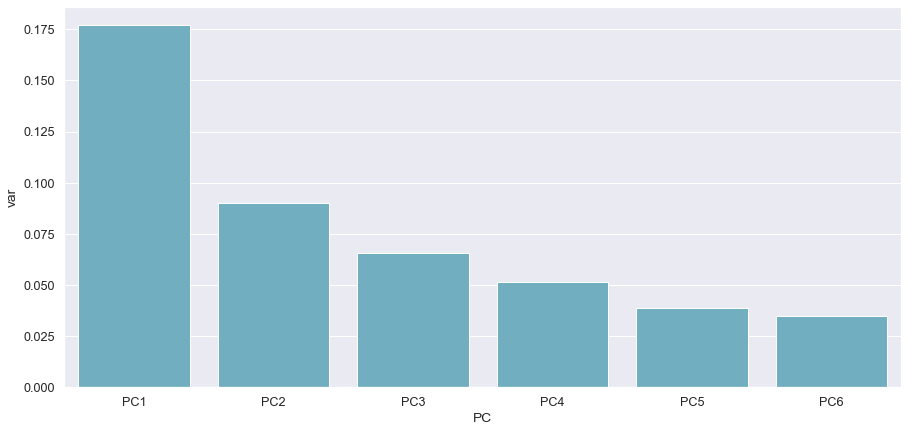

In [33]:
pca.explained_variance_ratio_


df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

#### First PC

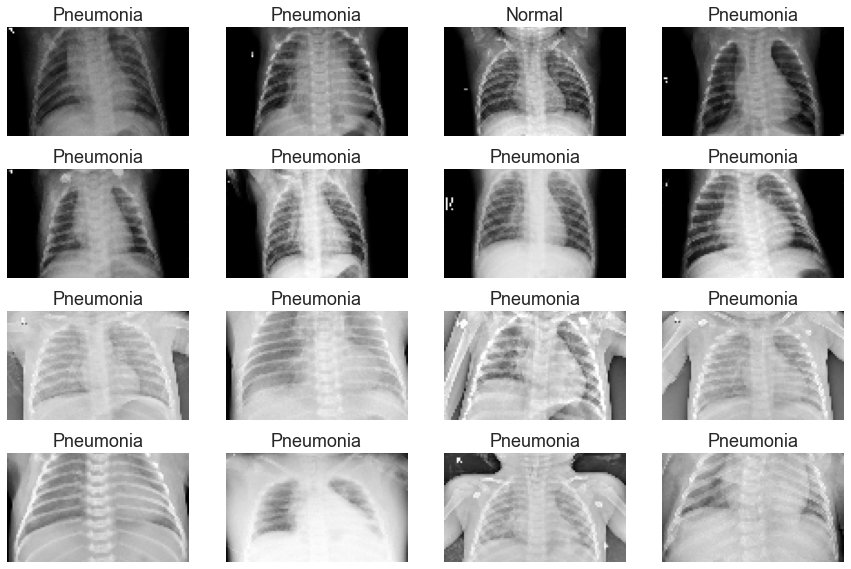

In [34]:
plot_pca_images(0, normal_normalized, pneumonia_normalized)

We can see that this represents the second PC of the original PCA analysis.

#### Second PC

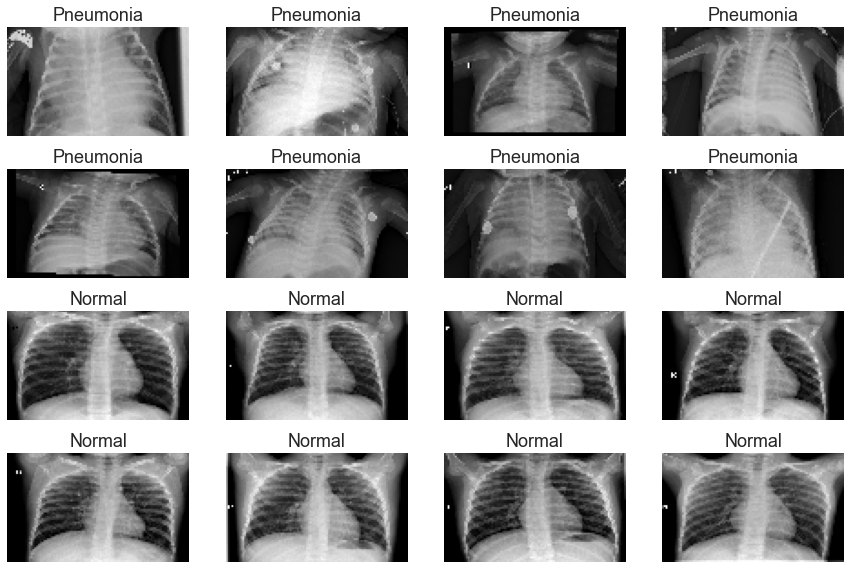

In [35]:
plot_pca_images(1, normal_normalized, pneumonia_normalized)

We can see that this represents the third PC from the original PCA analysis.

Lets re-check the third PC's accuracy and see if the accuracy has increased after normalizing with respect to the first PC.

##### Testing the pca  

In [36]:
NORMAL_LENGTH = len(normal_data)
PNEUMONIA_LENGTH = len(pneumonia_data)

predicted_as_normal = np.argpartition(combined_reduced[:, 1], NORMAL_LENGTH)[:NORMAL_LENGTH]
predicted_as_pneumonia = np.argpartition(combined_reduced[:, 1], -PNEUMONIA_LENGTH)[-PNEUMONIA_LENGTH:]

normal_count = 0
pneumonia_count = 0

for image in predicted_as_pneumonia:
    if labels[image] == "Pneumonia":
        pneumonia_count += 1

for image in predicted_as_normal:
    if labels[image] == "Normal":
        normal_count += 1

pneumonia_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
normal_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
total_accuracy = int((pneumonia_group_accuracy * PNEUMONIA_LENGTH + normal_group_accuracy * NORMAL_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))

print(f"The pneumonia group contains: {pneumonia_group_accuracy} % pneumonia images")
print(f"The normal group contains: {normal_group_accuracy} % normal images")
print(f"The total accuracy is: {total_accuracy} % \n")


The pneumonia group contains: 88 % pneumonia images
The normal group contains: 69 % normal images
The total accuracy is: 82 % 



Indeed as expected, by normalizing with respect to the first PC we have managed to increase further the accuracy of this classification tool. We have managed to reach an impressive 82% accuracy.

##### Visualizing the PCA

Through the analysis mentioned above, we have managed to reduce the problem almost entirely to one dimension. Let us once more visualize the PCA distrubition on a 2 dimensional graph to see the respective variance. 

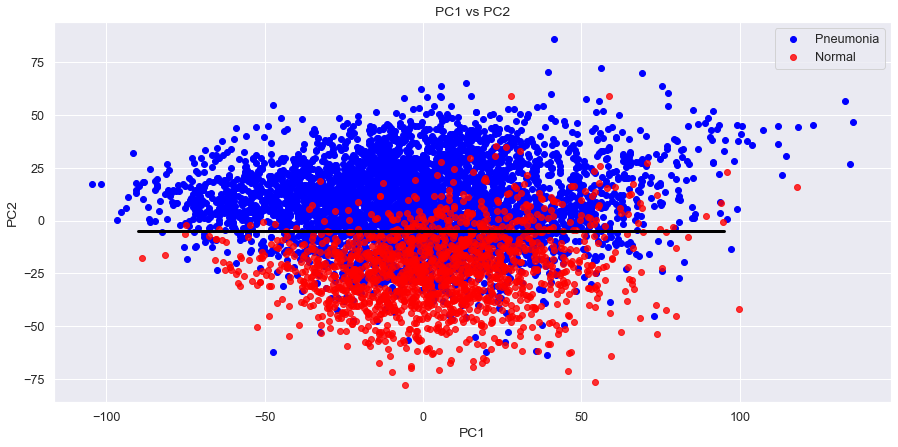

In [37]:
columns = ['PC' + str(i) for i in range(1,7)]
pca_df = pd.DataFrame(data=combined_reduced , columns=columns)


plt.scatter(pca_df.PC1[1575:], pca_df.PC2[1575:], c='blue')
plt.scatter(pca_df.PC1[:1575], pca_df.PC2[:1575], c='red', alpha=0.8)

plt.legend(['Pneumonia', 'Normal'])

plt.axhline(y=-5, xmin=0.1, xmax=0.8, color='black', linewidth=3)

plt.title('PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

As can be clearly seen, PC2 (PC3 before the dimension reduction) splits the data very well between the sick and healthy patients.

## Data Preperation For Classification

Before feeding the data to the model we need to perform various manipulations to conform to the format required by it. The following blocks of code will describe this process.

Firstly, we want to normalize all pixel values to be between 0 and 1. We will do this by finding the maximal value pixel of all pictures and dividing all pictures by this value.

In [38]:
MAX_VALUE = np.amax(normal_normalized + pneumonia_normalized)

normal_final = []
pneumonia_final = []

normal_final_flattened = []
pneumonia_final_flattened = []

for index, image in enumerate(normal_normalized):
    normal_final.append(image / MAX_VALUE)
    
for index, image in enumerate(pneumonia_normalized):
    pneumonia_final.append(image / MAX_VALUE)

for index, image in enumerate(normal_normalized_flattened):
    normal_final_flattened.append(image / MAX_VALUE)
    
for index, image in enumerate(pneumonia_normalized_flattened):
    pneumonia_final_flattened.append(image / MAX_VALUE)

Following that, we would like to split the data to train, validation and test groups. In order to use our data in multiple and variant models, we would split and adjust it in different ways with the use of NumPy and Sklearn libraries:

In [39]:
normal_labels = [0]*len(normal_final)
pneumonia_labels = [1]*len(pneumonia_final)

normal_train_with_val_data, normal_test_data, normal_train_with_val_labels, normal_test_labels = train_test_split(normal_final, normal_labels, test_size=0.33)
pneumonia_train_with_val_data, pneumonia_test_data, pneumonia_train_with_val_labels, pneumonia_test_labels = train_test_split(pneumonia_final, pneumonia_labels, test_size=0.33)

normal_train_data, normal_valid_data, normal_train_labels, normal_valid_labels = train_test_split(normal_train_with_val_data, normal_train_with_val_labels, test_size=0.2)
pneumonia_train_data, pneumonia_valid_data, pneumonia_train_labels, pneumonia_valid_labels = train_test_split(pneumonia_train_with_val_data, pneumonia_train_with_val_labels, test_size=0.2)

train_data = normal_train_data + pneumonia_train_data
train_labels = normal_train_labels + pneumonia_train_labels
NN_train_labels = to_categorical(train_labels, num_classes=2) 

valid_data = normal_valid_data + pneumonia_valid_data
valid_labels = normal_valid_labels + pneumonia_valid_labels
NN_valid_labels = to_categorical(valid_labels, num_classes=2) 

test_data = normal_test_data + pneumonia_test_data
test_labels = normal_test_labels + pneumonia_test_labels
NN_test_labels = to_categorical(test_labels, num_classes=2) 

train_data = np.array(train_data)
train_labels = np.array(train_labels)
NN_train_labels = np.array(NN_train_labels)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
NN_valid_labels = np.array(NN_valid_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
NN_test_labels = np.array(NN_test_labels)



The reason for the two types of labels is that the first one will be fed to the naive bayes and the second one will be fed to the neural network as it requires the labels to be categorical.

We now create the flattened data by simply reshaping the above variables to flat using numpy.reshape:


In [40]:
flatten_train_data = np.array([])
flatten_valid_data = np.array([])
flatten_test_data = np.array([])

flatten_train_data = train_data.reshape(train_data.shape[0],-1)
flatten_valid_data = valid_data.reshape(valid_data.shape[0],-1)
flatten_test_data = test_data.reshape(test_data.shape[0],-1)

train_data = train_data.reshape(train_data.shape[0], 60, 100, 1)
valid_data = valid_data.reshape(valid_data.shape[0], 60, 100, 1)
test_data = test_data.reshape(test_data.shape[0], 60, 100, 1)

Now our data is ready to use. Lets begin training the algorithm.

## Naive Bayes Classification Model
As seen in the PCA section, we can find simpler methods to predict and classify our data. In this section we will use a statistical method called naive bayes to attempt to analyze and extract useful information from the dataset.

Naive bayes takes a single 1-dimension vector as input and makes a prediction based on the values in the vector. In our case, we will feed the naive bayes algorithm a vector which will be the flattened image and the prediction will be either 'normal' or 'pneumonia'.

In [41]:
def plot_NB_confusion_matrix(test_model, testing_data, testing_labels, title):
    # Get predictions
    prediction = test_model.predict(testing_data)

    # Original labels
    orig_test_labels = testing_labels

    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, prediction)
    
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.rcParams["figure.figsize"] = (7,6)

    sns.heatmap(cm,cmap= "Reds", linecolor = 'black' ,
                linewidth = 1 , annot = True, fmt='',
                xticklabels = ['Normal', 'Pneumonia'],
                yticklabels = ['Normal', 'Pneumonia']).set(xlabel='PREDICTED', ylabel='ACTUAL', title=title)
    plt.ylim([2,0])
    plt.show()
    
    # Calculate the final accuracy of each condition
    tn, fp, fn, tp = cm.values.ravel()
    print(f"Normal accuracy test score: {int(100*(tn/(tn+fp)))}%" )        
    print(f"Pneumonia accuracy test score: {int(100*(tp/(tp+fn)))}%" )
    print(f"Total accuracy test score: {int(100*((tn+tp)/(tn+fp+tp+fn)))}%")

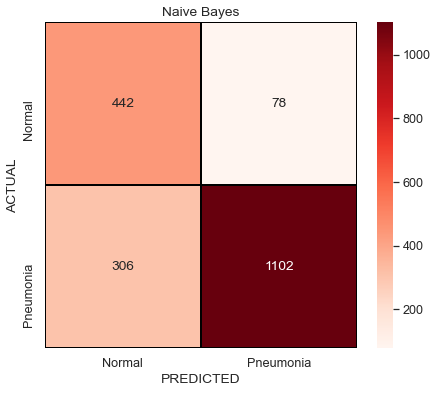

Normal accuracy test score: 85%
Pneumonia accuracy test score: 78%
Total accuracy test score: 80%


In [42]:
NB_flatten_train_data = np.asarray(flatten_train_data.tolist() + flatten_valid_data.tolist())
NB_train_labels =  np.asarray(train_labels.tolist() + valid_labels.tolist())

classifier = MultinomialNB()
classifier.fit(NB_flatten_train_data, NB_train_labels)

plot_NB_confusion_matrix(classifier, flatten_test_data, test_labels, "Naive Bayes")

The results indiciate a total accuracy of 80%. This isn't a bad result, but after seeing the PCA analysis perform better we believe that this model can be improved upon and as such we will try to do so. 

This will be done by instead of feeding the model the original image, we will instead use neural network methods to attempt to extract important features from the image and use them for the classification instead.

### Naive Bayes with Feature Extraction

In this part we will use Neural Networks as feature extraction models rather than classification tools. Our hope is that these models will find meaningful features in the images and then by feeding those to the naive bayes classification rather than the original image, we will be able to increase its accuracy.

There is no one particular way to do it, but the most common ways consist of building Neural Networks for image recognition, training them, and then extracting data from an intermediate layer of the model. The common belief is that this data will represent the original data as best as possible. 

### Autoencoder as Feature Extractor
Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data.
An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.
The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model.

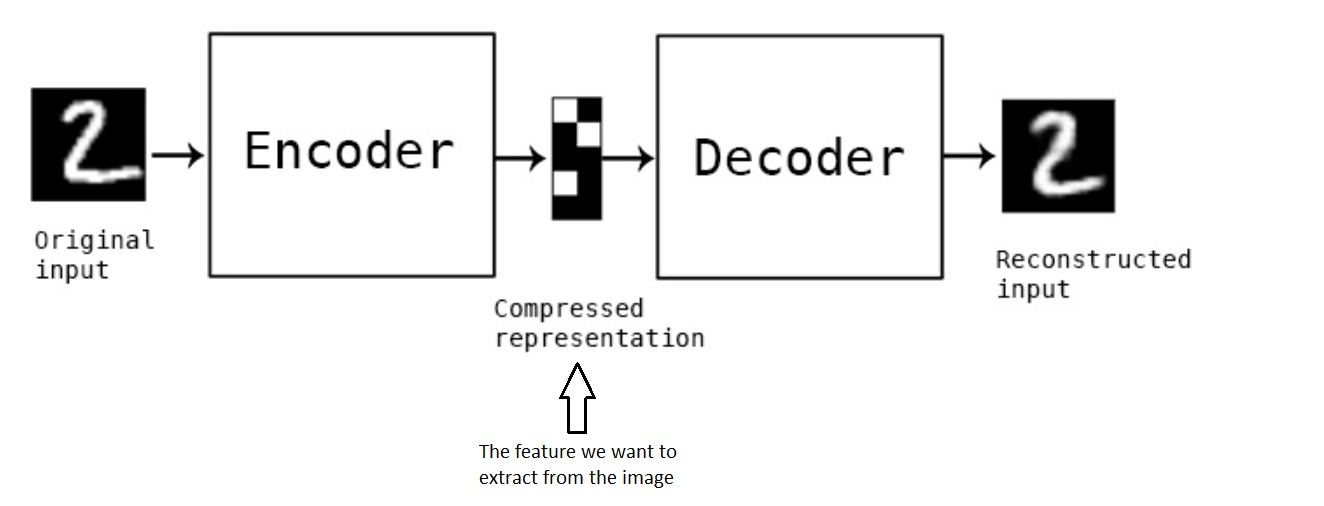

We will train an Autoencoder model to compress an image and reconstructe it back normal, as accurate as possible. Then we will take a vector from an intermediate layer that will represent the data.

In [43]:
input_img = layers.Input(shape=(60, 100, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

flatten_encoded = layers.Flatten(name='compressed')(encoded)
encoded = layers.Reshape((15, 25, 32))(flatten_encoded)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 100, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 100, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 25, 32)        0         
_________________________________________________________________
compressed (Flatten)         (None, 12000)             0         
_________________________________________________________________
reshape (Reshape)            (None, 15, 25, 32)       

In [44]:
autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size=128,
                shuffle=True,
                verbose=0,
                validation_data=(valid_data, valid_data))

Lets compare the images before and after the reconstructions to see wether or not they are similar as we would want.

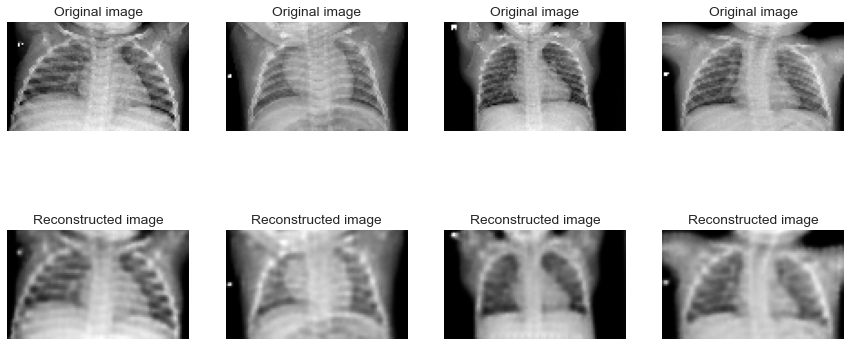

In [103]:
fig, axis = plt.subplots(2,4)
plt.rcParams["figure.figsize"] = (15,7)

for index, image in enumerate(test_data[:4]):
    axis[0,index].imshow(image, cmap="gray")
    axis[0,index].set_title('Original image')
    axis[0,index].axis("off")

for index, image in enumerate(autoencoder.predict(test_data[:4])[:4]):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Reconstructed image')
    axis[1,index].axis("off")

plt.show()

Visually the results look indeed similar. Lets use a tool called 'cosine similarity' which is a common tool for comparing similarities between vectors (which in our case, represnt the images) to quantatively approximate the similary between the images. 

In [46]:
def calc_cosine_similarity(img_A,img_B):
    result = cosine_similarity(img_A.flatten().reshape(1,-1),img_B.flatten().reshape(1,-1))
    result = 100*result[0][0]
    return result

In [47]:
cos_sim = []
predictions = autoencoder.predict(test_data)

for i in range(len(predictions)):
    cos_sim.append(calc_cosine_similarity(predictions[i],test_data[i]))

result = np.mean(cos_sim)
print(("The average similarity between images is: {:.2f}%").format(result))

The average similarity between images is: 99.70%


Needless to say, this results pleases us. We conclude that indeed the autoencoder has managed to recreate an accurate image. Let us now use the features extracted from the intermediate layer to re-attempt the classification.

Now let's extract the features 

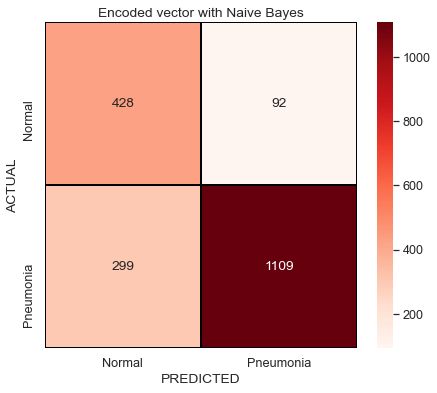

Normal accuracy test score: 82%
Pneumonia accuracy test score: 78%
Total accuracy test score: 79%


In [48]:
layer_name = 'compressed'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                       outputs=autoencoder.get_layer(layer_name).output)

NB_train_data = np.asarray(train_data.tolist() + valid_data.tolist())

encoder_train = intermediate_layer_model(NB_train_data)
encoder_test = intermediate_layer_model(test_data)

classifier = MultinomialNB()
classifier.fit(encoder_train, NB_train_labels)

plot_NB_confusion_matrix(classifier, encoder_test, test_labels, "Encoded vector with Naive Bayes")

We can see that this has not improved the results of the model. There can be a number of reasons for that. Rather than delving into this matter we will attempt a different way to classify the data.

### Img2vec
We used git repository for the module Img2vec. What this function does is exactly what it sounds like - Image to  vector embedding. This library uses the ResNet50 model in TensorFlow Keras, pre-trained on Imagenet, to generate image embeddings. resnet50 is a residual convolutional neural network with 25.5 million parameters trained on more than a million images from the ImageNet database. As the name suggests, it has a total of 50 layers: 48 convolution layers, 1 MaxPool layer and 1 Average Pool layer. 

The method defined below takes an image as input, and through feature extraction process it creates 1-dimensional vector of 2048 numeric values that represents the main features of the original image.This version of Img2vec is a clone of https://github.com/christiansafka/img2vec for TensorFlow Keras users. Due to problems we faced while downloading the package, we decided to copy the code directly from https://github.com/jaredwinick/img2vec-keras as can be seen below.

In [49]:
from tensorflow import keras
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np


_IMAGE_NET_TARGET_SIZE = (224, 224)


class Img2Vec(object):

    def __init__(self):
        
        model = resnet50.ResNet50(weights='imagenet')
        layer_name = 'avg_pool'
        self.intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer(layer_name).output)

    def get_vec(self, image_path):
        """ Gets a vector embedding from an image.
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """
        img = image.load_img(image_path, target_size=_IMAGE_NET_TARGET_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        
        return intermediate_output[0]
    
if __name__ == "main":
     pass  

##### Create Img2vec data
This part looks similar to what we did before, but in order to use images with the function IMG2VEC, the input must be of it's original file format: JPG.<br>
The next block of code will create the same sizes of datasets, but with JPG files instead of images(matrix of pixels)

In [50]:
vector_normal_labels = [0]*len(normal_data)
vector_pneumonia_labels = [1]*len(pneumonia_data)

normal_train_with_val_data, normal_test_data, normal_train_with_val_labels, normal_test_labels = train_test_split(NORMAL_FILES, vector_normal_labels, test_size=0.33)
pneumonia_train_with_val_data, pneumonia_test_data, pneumonia_train_with_val_labels, pneumonia_test_labels = train_test_split(PNEUMONIA_FILES, vector_pneumonia_labels, test_size=0.33)

normal_train_data, normal_valid_data, normal_train_labels, normal_valid_labels = train_test_split(normal_train_with_val_data, normal_train_with_val_labels, test_size=0.2)
pneumonia_train_data, pneumonia_valid_data, pneumonia_train_labels, pneumonia_valid_labels = train_test_split(pneumonia_train_with_val_data, pneumonia_train_with_val_labels, test_size=0.2)

raw_train_data = normal_train_data + pneumonia_train_data
raw_valid_data = normal_valid_data + pneumonia_valid_data
raw_test_data = normal_test_data + pneumonia_test_data

raw_train_data = np.array(raw_train_data)
raw_valid_data = np.array(raw_valid_data)
raw_test_data = np.array(raw_test_data)

#### Create vectors of our images

In [51]:
img2vec_train_data = []
img2vec_valid_data = []
img2vec_test_data = []

# intiate vectors
for img in tqdm(raw_train_data):
    img2vec_train_data.append(img2vec.get_vec(img))
    
for img in tqdm(raw_valid_data):
    img2vec_valid_data.append(img2vec.get_vec(img))
    
for img in tqdm(raw_test_data):
    img2vec_test_data.append(img2vec.get_vec(img)) 
    
# compress all data to numpy arrays
img2vec_train_data = np.array(img2vec_train_data)
img2vec_valid_data = np.array(img2vecr_valid_data)
img2vec_test_data = np.array(img2vec_test_data)

###  Naive Bayes with Img2vec 

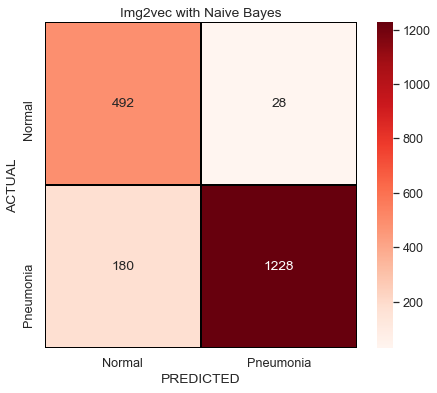

Normal accuracy test score: 94%
Pneumonia accuracy test score: 87%
Total accuracy test score: 89%


In [53]:
NB_img2vec_train_data = np.asarray(img2vec_train_data.tolist() + img2vec_valid_data.tolist())

classifier = MultinomialNB()
classifier.fit(NB_img2vec_train_data, NB_train_labels)

plot_NB_confusion_matrix(classifier, img2vec_test_data, test_labels, "Img2vec with Naive Bayes")

Impressive. The img2vec method performs great and by using the embedded vectors in Naive Bayes it recieved a classification accuaracy of 89% which greatly improves upon the original naive bayes accuracy.

### Conclusion Thus Far
We tested 3 types of data with Naive Bayes classifier to predict images as normal or pneumonia. 
- Original images as 1-dimensional vector.
- Features Extraction data from a train Autoencoder.
- Deep learning image embeddings using pre-trained ResNet50 - Img2vec.

Otiginal data Autoencoder Img2vec
Total accuracy           80%         79%     89%

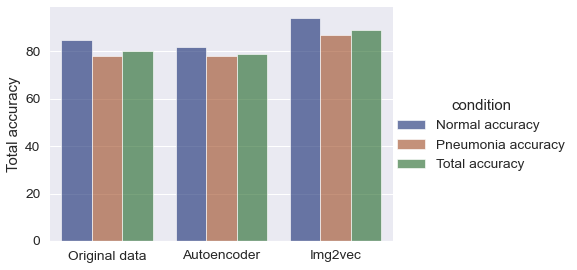

In [112]:
NB_results = pd.DataFrame({"Otiginal data" : ["80%"],
                    "Autoencoder" : ["79%"],
                    "Img2vec" : ["89%"]}, index=['Total accuracy'])

df  = pd.DataFrame({"method" : ["Original data", "Autoencoder", "Img2vec",
                               "Original data", "Autoencoder", "Img2vec",
                                "Original data", "Autoencoder", "Img2vec"],
                "value" : [85, 82, 94,
                          78, 78, 87,
                          80, 79, 89],
                "condition" : ["Normal accuracy", "Normal accuracy", "Normal accuracy",
                               "Pneumonia accuracy", "Pneumonia accuracy", "Pneumonia accuracy",
                               "Total accuracy", "Total accuracy", "Total accuracy"]},
                index = [1, 2, 3,4,5,6,7,8,9])

plot = sns.catplot(
    data=df, kind="bar",
    x="method", y="value", hue="condition",
    ci="None", palette="dark", alpha=.6, height=4,aspect=11.7/8.27
)
plot.despine(left=True)
plot.set_axis_labels("", "Total accuracy")

sns.set(font_scale=1.25)
NB_results

## Basic neural network

After finishing testing our data with Naive Bayes models it is finally time to create a Neural Network model and train it on the data. The first step will be to build a relatively simple neural network, that will recieve a 1-dimensional vector representing each image.

In [55]:
def basic_neural_network(input_shape):
    model = Sequential()

    model.add(Dense(512, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    model.summary()
    return model

In [56]:
model = basic_neural_network((100*60,))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

Now that we have a Neural Network model, let's train it. However, before actually training it we will add plotting functions, early stop and learning decay parameters , in order to improve the model's learning process and to save resources when the learning process is not improving any more:

In [57]:
def plot_results(test_model, testing_data, testing_labels):
    score = test_model.evaluate(testing_data, testing_labels, verbose=1)
    print("\nThe final results are:\n")
    print(f'Test loss: {int(100*score[0])}%')
    print(f'Test accuracy: {int(100*score[1])}%')

    
    
def plot_history(model_fit):
    plt.rcParams["figure.figsize"] = (15,8)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_fit.history[metric])
        ax[i].plot(model_fit.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

        
        
def plot_NN_confusion_matrix(test_model, testing_data, testing_labels, title):
    # Get predictions
    prediction = test_model.predict(testing_data, batch_size=16)
    prediction = np.argmax(prediction, axis=-1)
    
    # Original labels
    orig_test_labels = np.argmax(testing_labels, axis=-1)
    
    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, prediction)
    
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.rcParams["figure.figsize"] = (7,6)
    sns.heatmap(cm,cmap= "Reds", linecolor = 'black' ,
                linewidth = 1 , annot = True, fmt='',
                xticklabels = ['Normal', 'Pneumonia'],
                yticklabels = ['Normal', 'Pneumonia']).set(xlabel='Predicted', ylabel='Actual', title=title)
    plt.show()
    
    tn, fp, fn, tp = cm.values.ravel()
    print(f"Normal accuracy test score: {int(100*(tn/(tn+fp)))}%" )        
    print(f"Pneumonia accuracy test score: {int(100*(tp/(tp+fn)))}%" )
    print(f"Total accuracy test score: {int(100*((tn+tp)/(tn+fp+tp+fn)))}%")

In [58]:
LR_reduce = ReduceLROnPlateau(monitor='val_accuracy',
                           factor=.5,
                           patience=10,
                           min_lr=.000001,
                           verbose=1)

ES_monitor = EarlyStopping(monitor='val_loss', patience=20)

Due to the imbalance that exists in the dataset which was mentioned in the introduction, our model might be biased. A solution we propose is to create class weights for the models we are about to train and through that make the learning process more accurate.

In [111]:
weights = class_weight.compute_class_weight('balanced',
                                                 [0, 1],
                                                 train_labels)
weights_dict = dict(enumerate(weights))

Pass classes=[0, 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


The model now will get compiled and fit to the data:

In [60]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_NN = model.fit(flatten_train_data, NN_train_labels,
                    batch_size=128,
                    epochs=100,
                    verbose=0,
                    shuffle=True,
                    validation_data=(flatten_valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])


Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


In [61]:
plot_results(model, flatten_test_data, NN_test_labels)

61/61 [==============================] - 0s 6ms/step - loss: 0.1730 - accuracy: 0.9409

The final results are:

Test loss: 17%
Test accuracy: 94%


This results are great. It looks like our simplest model classifies normal and pneumonia images with an accuracy of 94%. In order to understand the results better, let's plot them first in as graph and confusion matrix:

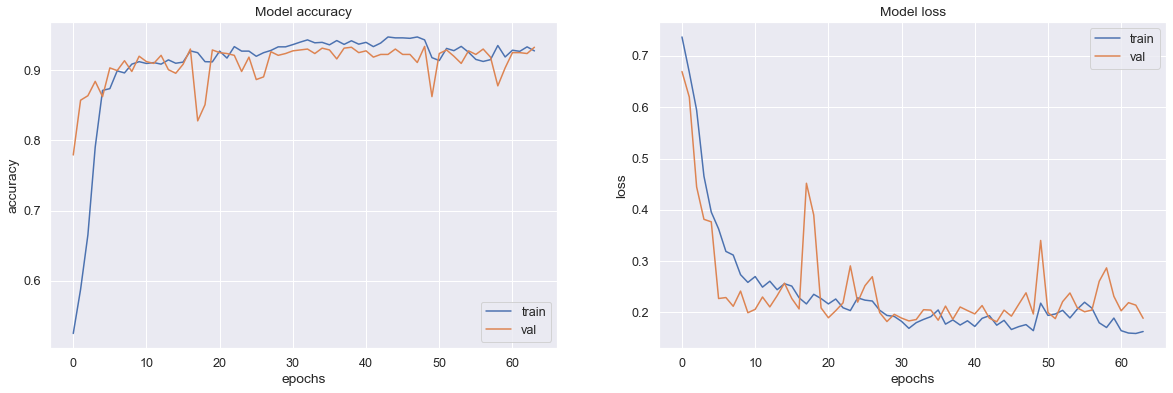

In [62]:
plot_history(basic_NN)

This result brings some concerns about the model overfitting  the data. Let's test the model on an unrelated data set - the test data set.

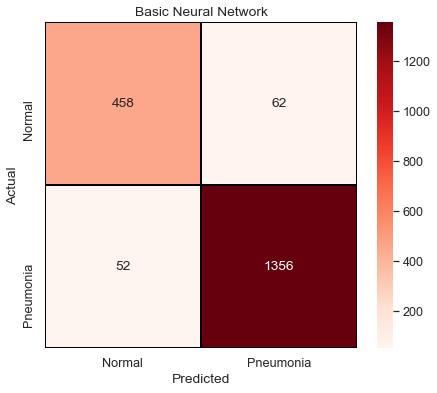

Normal accuracy test score: 88%
Pneumonia accuracy test score: 96%
Total accuracy test score: 94%


In [63]:
plot_NN_confusion_matrix(model, flatten_test_data, NN_test_labels, "Basic Neural Network")

In contrast to our concern, these results show that the model actually performs with an accuaracy of 94% on an independent dataset. This is a very reassuring result.

### Basic neural network with img2vec
After seeing the results of the img2vec model with the Naive Bayes we will now test it again using a neural network that we will build.

In [64]:
model = basic_neural_network((2048,))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)               

In [65]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_NN_with_img2vec = model.fit(img2vec_train_data, NN_train_labels,
                        batch_size=128,
                        epochs=100,
                        verbose=0,
                        shuffle=True,
                        validation_data=(img2vec_valid_data, NN_valid_labels),
                        class_weight=weights_dict,
                        callbacks = [LR_reduce, ES_monitor])


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


In [66]:
plot_results(model, img2vec_test_data, NN_test_labels)

61/61 [==============================] - 0s 4ms/step - loss: 0.1876 - accuracy: 0.9461

The final results are:

Test loss: 18%
Test accuracy: 94%


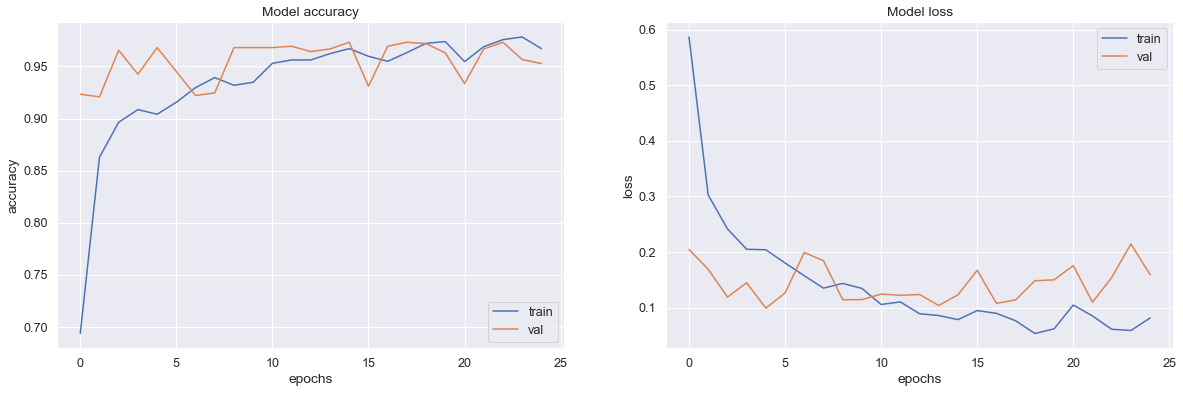

In [67]:
plot_history(basic_NN_with_img2vec)

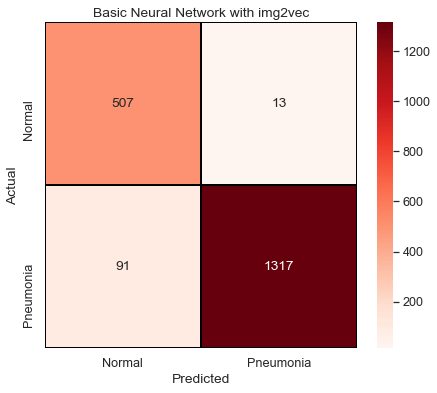

Normal accuracy test score: 97%
Pneumonia accuracy test score: 93%
Total accuracy test score: 94%


In [68]:
plot_NN_confusion_matrix(model, img2vec_test_data, NN_test_labels, "Basic Neural Network with img2vec")

By using the img2vec as our input to the basic neural network rather than the original raw dataset we manage to maintain its accuracy to a whopping 94%. This result is extremly good and not one that can much be improved upon. Our last attempt will be the notorious Convolutional Neural Network.

## Convolutional Neural Network
A convolutional Neural Network is a neural network that takes 2d images instead of 1d vectors. The reson for that is that a convolutional neural network was made and designed mainly for the classification of images. Its advantages over regular neural networks are:
1. The neural networks takes into account the neighborhood of each pixel, rather than its location on the grid alone.
2. It is dependant on the location of the features on an image, only to their properties
3. It can detect image features on a large scale (A face, a car, and so fourth)

In the following code blocks will attempt classify our images using a CNN by building a model and training it on our data.

### first attempt

In [69]:
CNN_model = Sequential()

CNN_model.add(Conv2D(32, kernel_size = 4, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(128, kernel_size = 2, activation="relu", padding='same'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Flatten())

CNN_model.add(Dense(256, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(128, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(64, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(2, activation='softmax'))

CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 100, 32)       544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 25, 128)       32896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 12, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10752)            

Now we can compile the model with 'adam' optimizer and a binary cross entropy loss function that fits  the kind of classification we are dealing with.

In [70]:
CNN_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
history = CNN_model.fit(train_data, NN_train_labels,
                    batch_size=128,
                    epochs=100,
                    verbose=0,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

### Results

In [72]:
plot_results(CNN_model, test_data, NN_test_labels)

61/61 [==============================] - 4s 63ms/step - loss: 0.2193 - accuracy: 0.9564

The final results are:

Test loss: 21%
Test accuracy: 95%


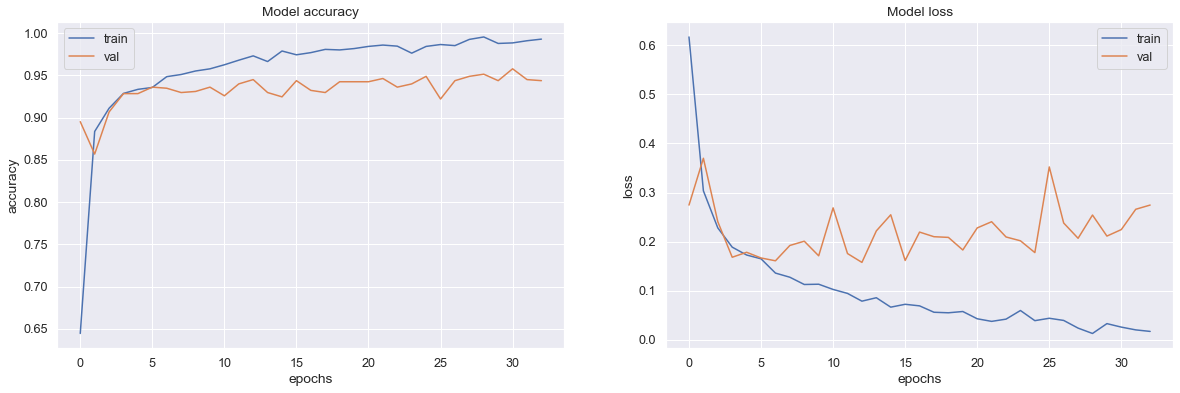

In [73]:
plot_history(history)

The model seems to stop improving from epoch 5 to the end, eventhough he managed to acheive great accuracy. Lets once again test the data on the independent test data set and print the result on a confusion matrix.

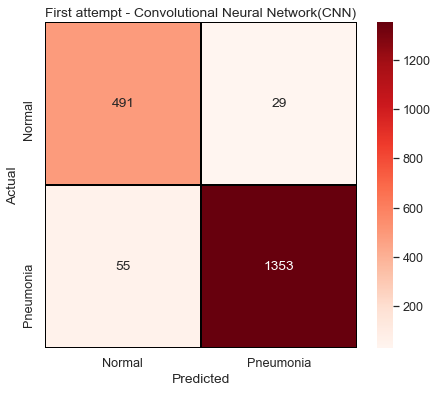

Normal accuracy test score: 94%
Pneumonia accuracy test score: 96%
Total accuracy test score: 95%


In [74]:
plot_NN_confusion_matrix(CNN_model, test_data, NN_test_labels, "First attempt - Convolutional Neural Network(CNN)")

Like in the previous neural network, there seems to have been no overfitting, with the model managing to predict the data with a great accuracy of 95%, which consdired another improvment in classification's accuracy.

### Second attempt
Let's try to double the conv layers, especially at the early process of the model, hopefully it will add some value to the learning abbilities of the model.

In [75]:
CNN_condense_model = Sequential()

CNN_condense_model.add(Conv2D(32, kernel_size = 2, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_condense_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_condense_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_condense_model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(3, 3)))

CNN_condense_model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
CNN_condense_model.add(Conv2D(256, kernel_size = 5, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(4, 4)))

CNN_condense_model.add(Flatten())

CNN_condense_model.add(Dense(256, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(128, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(64, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(2, activation='softmax'))

CNN_condense_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 60, 100, 32)       160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 100, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 50, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 50, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 50, 128)       131200    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 16, 128)      

In [76]:
CNN_condense_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [77]:
history = CNN_condense_model.fit(train_data, NN_train_labels,
                    batch_size = 128,
                    epochs=100,
                    verbose=0,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])


Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


### Results


In [78]:
plot_results(CNN_condense_model, test_data, NN_test_labels)

61/61 [==============================] - 19s 311ms/step - loss: 0.2733 - accuracy: 0.9554

The final results are:

Test loss: 27%
Test accuracy: 95%


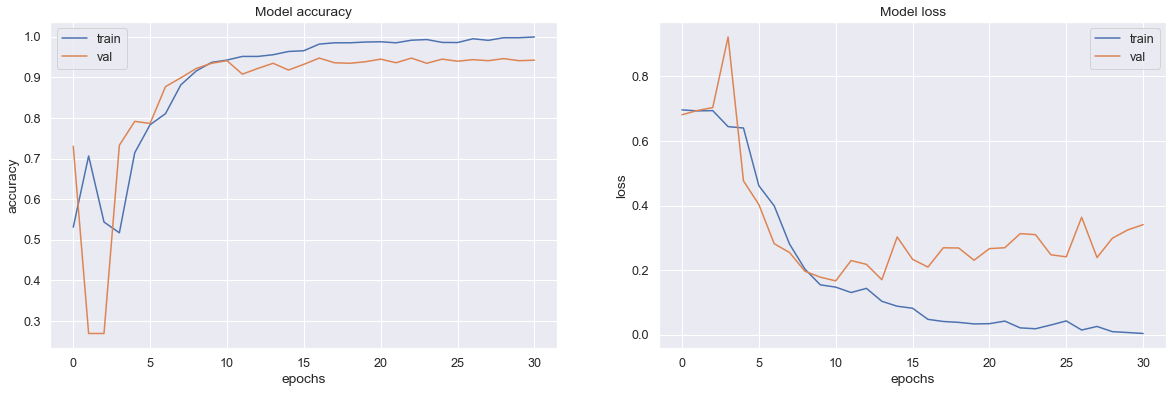

In [79]:
plot_history(history)

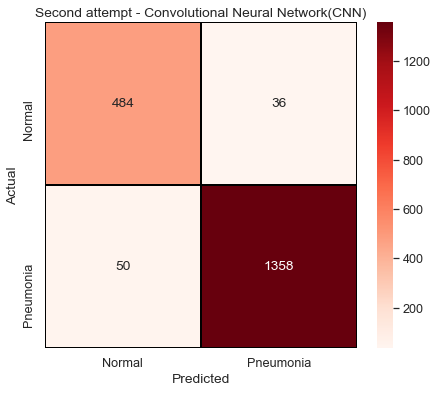

Normal accuracy test score: 93%
Pneumonia accuracy test score: 96%
Total accuracy test score: 95%


In [80]:
plot_NN_confusion_matrix(CNN_condense_model, test_data, NN_test_labels, "Second attempt - Convolutional Neural Network(CNN)")

The results are still great but didn't improve in comparison to the first attempt.

## SHAP Values

Explaining shap is rather complicated, so we decided to present an explanation that can be seen on a data science article on the shap - https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

SHAP — which stands for SHapley Additive exPlanations — is probably the state of the art in Machine Learning explainability. This algorithm was first published in 2017 by Lundberg and Lee (https://arxiv.org/abs/1705.07874) and it is a brilliant way to reverse-engineer the output of any predictive algorithm.
SHAP values are used whenever you have a complex model (could be a gradient boosting, a neural network, or anything that takes some features as input and produces some predictions as output) and you want to understand what decisions the model is making.
SHAP values are based on Shapley values, a concept coming from game theory. In a nutshell, the Shapley value is a solution concept in cooperative game theory which describe the impact of each player in the game on acheiving the common goal, and by that can define how much each player "contribute" in acheiving the goal.
When used in Machine Learning, the "game" stands for observation by a model, and the "players" are the features tested by the model. This gives us the option to look behind the scene of the decition making of the Neural Network model and look which feature impact the most on a given prediction.
A CNN model predict WHAT is every image, and the SHAP values tells us WHY.

In this part we will take the wrong prediction of the CNN models and try to understand where the models fall short. We used Softmax Activation function as our output layer. It is used to normalize the output of the network to a probability distribution over predicted output classes, which in our case we have only 2: Normal or Pneumonia. We will use the values of the last layer to find the wrong predictions of our model and examine thier SHAP values.
This code was taken from https://github.com/slundberg/shap.

#### Functions to test WRONG predictions

In [81]:
NUM_OF_TOP_MISTAKES = 10

# calculate the wrong predictions, distribution of answers by the model, top wrong predictions images
def calc_SHAP_mistakes_values(model, testing_data, testing_labels):
    
    pred = model.predict(testing_data)

    Y_pred_classes = np.argmax(pred,axis = 1) 
    Y_true = np.argmax(testing_labels,axis = 1)

    errors = (Y_pred_classes - Y_true != 0)

    wrong_pred_labels = Y_pred_classes[errors]
    wrong_pred_distribution = pred[errors]
    true_labels = Y_true[errors]
    wrong_images = testing_data[errors]


    Y_pred_errors_prob = np.max(wrong_pred_distribution, axis = 1)
    true_prob_errors = np.diagonal(np.take(wrong_pred_distribution, true_labels, axis=1))
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    top_mistakes = sorted_dela_errors[-NUM_OF_TOP_MISTAKES:]
    
    return top_mistakes, wrong_images, wrong_pred_labels, true_labels, wrong_pred_distribution


# plot the wrong predictions
def plot_mistakes(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            
            if pred_errors[error] == 1:
                prediction = "Pneumonia"
            else:
                prediction = "Normal"
                
            if obs_errors[error] == 1:
                original = "Pneumonia"
            else:
                original = "Normal"
                
            ax[row,col].imshow((img_errors[error]).reshape((60,100)), cmap="gray")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(prediction,original))
            n += 1
    plt.rcParams["figure.figsize"] = (15,8)
    plt.show()
    
    
# plot the SHAP values of images with the answers probability    
def plot_SHAP_values(model, testing_data, wrong_pred, wrong_pred_index):

    explainer = shap.DeepExplainer(model, (testing_data[0:100])) # amount of images to create background 
    
    conditions = ["Normal", "Pneumonia"]

    for i in wrong_pred_index[:3]:     #Check out the 5 data that the model has mistakenly predicted.
    
    #Calculates the SHAP value.
        shap_values = explainer.shap_values(wrong_pred[[i]])
    
        if wrong_pred_labels[i] == 1:
            prediction = "Pneumonia"
        else:
            prediction = "Normal"
    
        if true_labels[i] == 1:
            original = "Pneumonia"
        else:
            original = "Normal"
        
        
        #calculate the answers probability
        index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(pred_dist[i][num]) for num, x in enumerate(conditions)]).reshape(1,2)
        print("Predicted label :{}\nTrue label :{}".format(prediction,original))
    
        #Displays the results.
        shap.image_plot(shap_values, wrong_pred[[i]] ,index_names ,show=False)
#        plt.figure(figsize=(15,8))
        plt.show()

### First attempt


#### Testing SHAP values of wrong predictions by our model

In [82]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(CNN_model, test_data, NN_test_labels)

Let's plot first the 10 top mistakes to see it in our own eyes

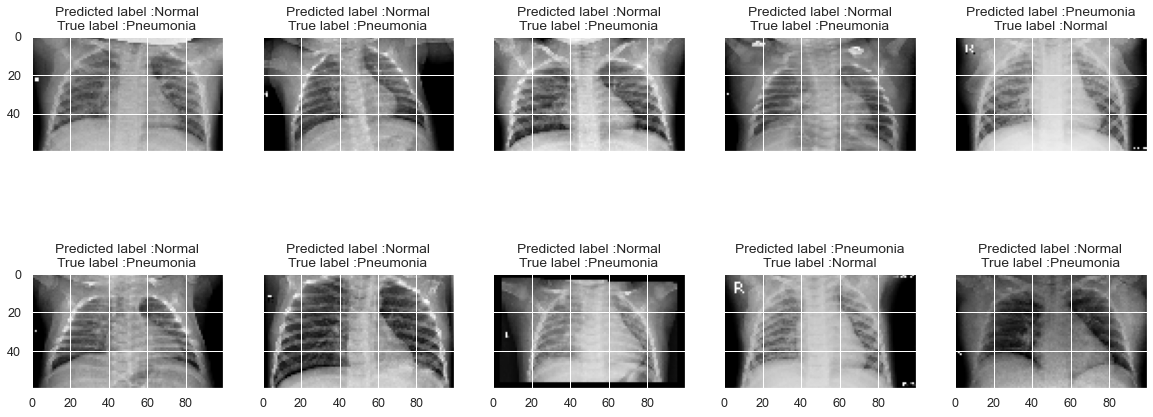

In [83]:
plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

Now it's time to let the SHAP method do his magic:

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Predicted label :Normal
True label :Pneumonia


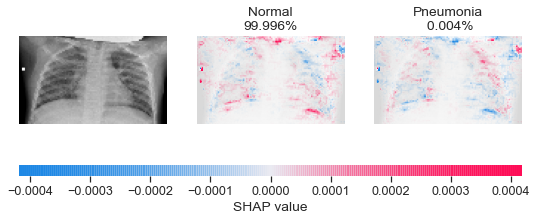

Predicted label :Normal
True label :Pneumonia


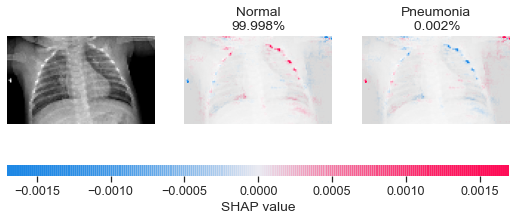

Predicted label :Normal
True label :Pneumonia


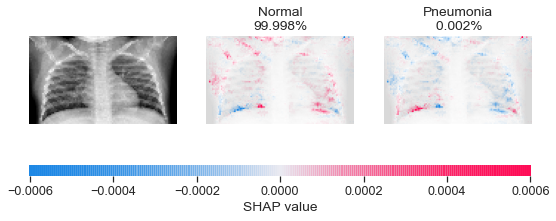

In [84]:
plot_SHAP_values(CNN_model, test_data, wrong_images, top_mistakes)

What we see is the images from the "model's eye" perspective, with the class title of each image and the percentage of certainty in the model's prediction for that class.
For each class, the model paints the image in red the areas he thinks that strengthen his prediction and blue for the areas that weakens his prediction. The colors correlate between the classes because the models focuses on an area that naturally strengthen one prediction and weakens the others one.

In the first and third image, it looks like our model focuses on the ribcage area and especially the close area surrounding the lungs, but for some reason mistakenly associate the image's data for the wrong class.<br>In the second image the model just looks at brightest points of the image.

Let's check the second CNN and see if we can formulate a conclusion for both models.

### Second attempt

In [85]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(CNN_condense_model, test_data, NN_test_labels)

Again we will plot the 10 top mistakes

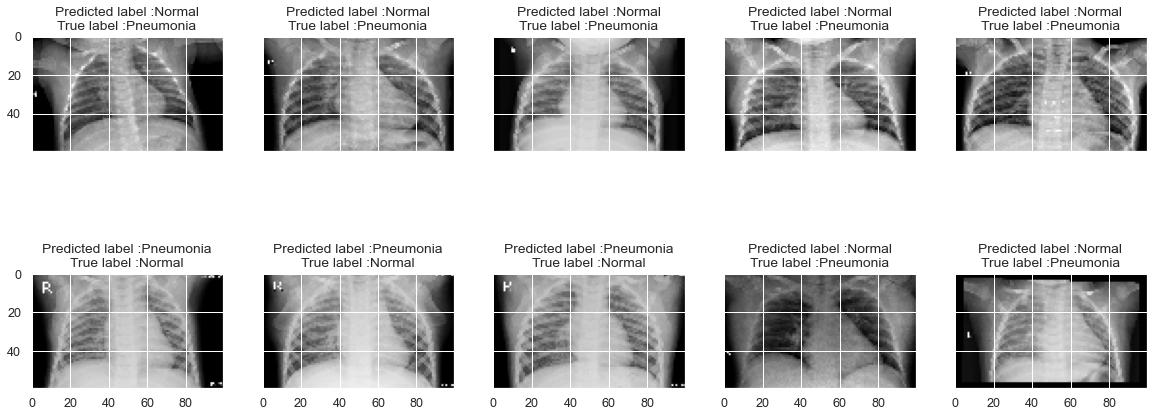

In [86]:
plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

And run SHAP 

Predicted label :Normal
True label :Pneumonia


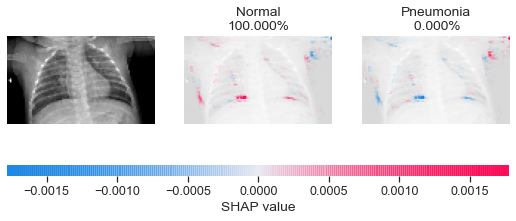

Predicted label :Normal
True label :Pneumonia


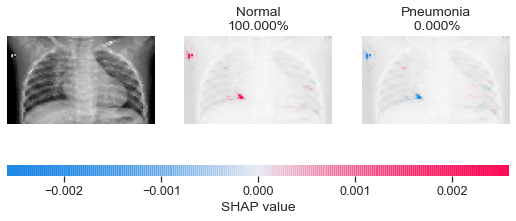

Predicted label :Normal
True label :Pneumonia


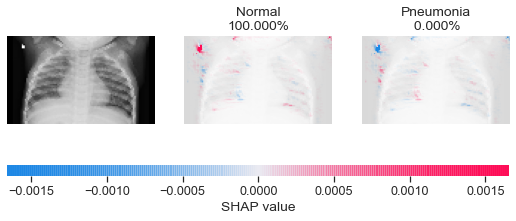

In [87]:
plot_SHAP_values(CNN_condense_model, test_data, wrong_images, top_mistakes)

In the second and third images we see again a  model that focuses on the brightest areas in the images, especially on medical data written on the side of the body. We present some inages that contain medical devices and written data in them on the EDA section, but didn't think we will actually meet them again.<br>In the first image we see that like the first CNN model, this model looks at the right place but makes the wrong assessment to what he sees.

After seeing both model, we feel like we understand a bit better what the models are doing and why they fail to predict some images. Each model seems to focus on two main things:
- The first CNN model focuses on bright keypoint in the images in some cases, and in others focuses on the surrounding area of the lungs, which we think is the right area to look on, but missed or miscalculate correctly what he sees. 
- The second CNN also focused on bright areas in the images, and on medical data in the images that distract him from what we are looking for, which is pneumonia prediction.

We feel like we have an idea of how to improve the models a bit more. Because we see the models, and mainly the first CNN, looks on the right area in the images, we think to add random rotation, orientation and scale to some images. This will hopfully help the model not only look on the right area, but also to "see" the data from another prespective, sort of speak, and predict correctly what he sees.

### Last attempt
#### Data Transformations and Augmentation
Image transformations and augmentation is an efficient way to diversify data and to generalize a model, we will try to use it to improve our model's predictions, according to our finding in the SHAP section.

We will use a built in keras function to do so, and we will change images rotation, orientation and scale

In [88]:
# construct the training image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             shear_range=.15,
                              zoom_range=.15,
                              width_shift_range=.15,
                              height_shift_range=.15,
                              horizontal_flip=True,
                              fill_mode='nearest')

## CNN with Data Generation
We will use the first CNN model who perform better than the second one, and looks like our solution of transformation and augmentation data fits his needs better accordingly to the SHAP analysis. First, we will build the model again and compile it.

In [89]:
CNN_gen_model = Sequential()

CNN_gen_model.add(Conv2D(32, kernel_size = 4, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Conv2D(128, kernel_size = 2, activation="relu", padding='same'))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Flatten())

CNN_gen_model.add(Dense(256, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(128, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(64, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(2, activation='softmax'))

CNN_gen_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 60, 100, 32)       544       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 25, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 25, 128)       32896     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 12, 128)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10752)            

In [90]:
CNN_gen_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Now we will train it with the addition of the Image Data Generator function mentioned above

In [91]:
history = CNN_gen_model.fit(datagen.flow(train_data, NN_train_labels, batch_size=128 ),
                    epochs=100,
                    verbose=0,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])


Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


In [92]:
plot_results(CNN_gen_model, test_data, NN_test_labels)

61/61 [==============================] - 4s 66ms/step - loss: 0.1524 - accuracy: 0.9367

The final results are:

Test loss: 15%
Test accuracy: 93%


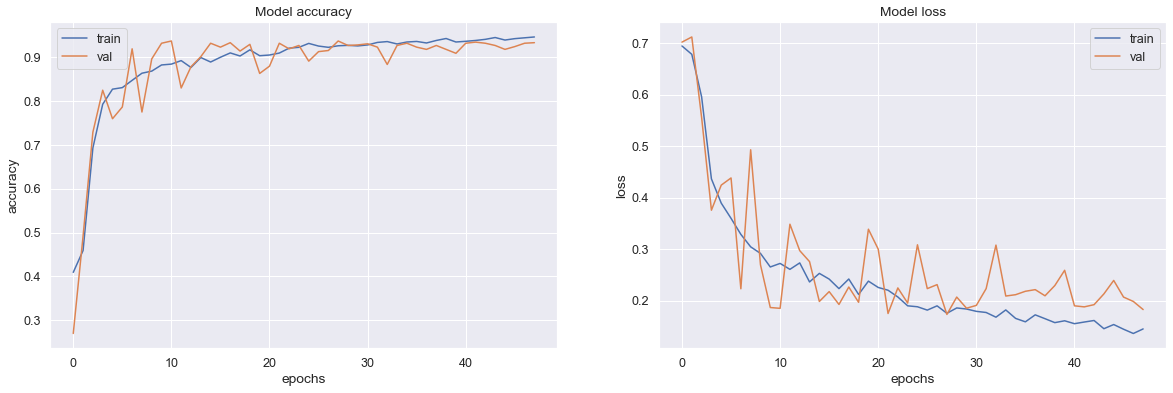

In [93]:
plot_history(history)

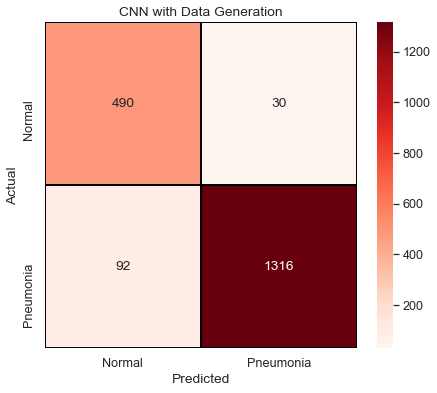

Normal accuracy test score: 94%
Pneumonia accuracy test score: 93%
Total accuracy test score: 93%


In [94]:
plot_NN_confusion_matrix(CNN_gen_model, test_data, NN_test_labels, "CNN with Data Generation")

We actually hoped for some improvment but it didn't happen.This ;ast model perform with 93% accuracy in prediction an healthy or sick images. We can't be disappointed with the results, but we thought the data generation will give our model the last touch he was missing.

# Conclusions
### Results


Original Bayes Autoencoder Img2vec Bayes Original NN  \
Total accuracy            80%         79%           89%         94%   

               Img2vec NN First CNN Second CNN DataGen CNN  
Total accuracy        94%       95%        95%         93%

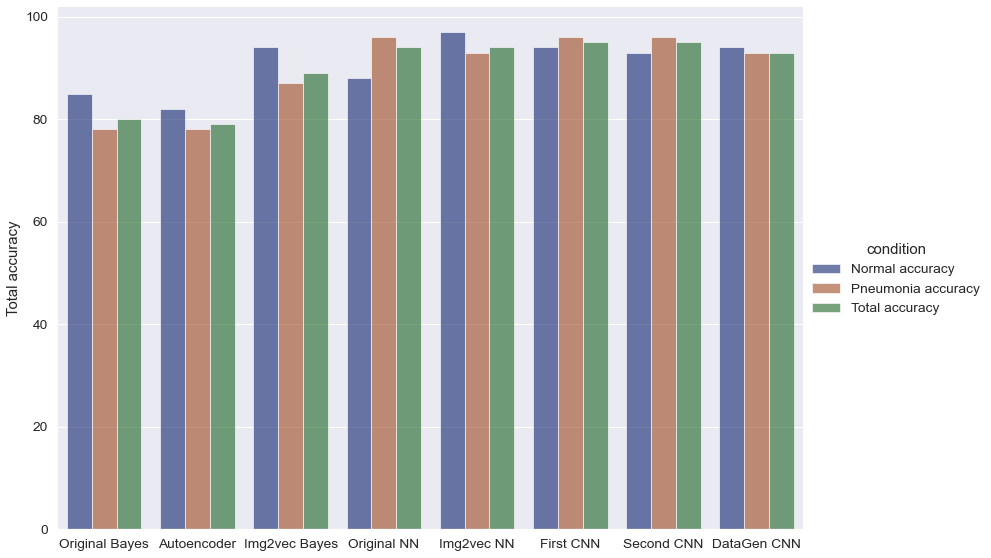

In [114]:
total_results = pd.DataFrame({"Original Bayes" : ["80%"],
                    "Autoencoder" : ["79%"],
                    "Img2vec Bayes" : ["89%"],
                             "Original NN": ["94%"],
                             "Img2vec NN": ["94%"],
                             "First CNN": ["95%"],
                             "Second CNN": ["95%"], 
                             "DataGen CNN": ["93%"]}, index=['Total accuracy'])

df1  = pd.DataFrame({"method" : ["Original Bayes", "Autoencoder", "Img2vec Bayes", "Original NN", "Img2vec NN", "First CNN","Second CNN", "DataGen CNN",
                                "Original Bayes", "Autoencoder", "Img2vec Bayes", "Original NN", "Img2vec NN", "First CNN","Second CNN", "DataGen CNN",
                                "Original Bayes", "Autoencoder", "Img2vec Bayes", "Original NN", "Img2vec NN", "First CNN","Second CNN", "DataGen CNN"],
                "value" : [85, 82, 94, 88, 97, 94, 93, 94,
                          78, 78, 87, 96, 93, 96, 96, 93,
                          80, 79, 89, 94, 94, 95, 95, 93],
                "condition" : ["Normal accuracy", "Normal accuracy", "Normal accuracy", "Normal accuracy", "Normal accuracy", "Normal accuracy", "Normal accuracy", "Normal accuracy",
                              "Pneumonia accuracy", "Pneumonia accuracy", "Pneumonia accuracy", "Pneumonia accuracy", "Pneumonia accuracy", "Pneumonia accuracy", "Pneumonia accuracy", "Pneumonia accuracy",
                              "Total accuracy", "Total accuracy", "Total accuracy", "Total accuracy", "Total accuracy", "Total accuracy", "Total accuracy", "Total accuracy"]},
                index = [1, 2, 3,4,5,6,7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

plot = sns.catplot(
    data=df1, kind="bar",
    x="method", y="value", hue="condition",
    ci="None", palette="dark", alpha=.6, height=8,aspect=11.7/8.27
)
plot.despine(left=True)
plot.set_axis_labels("", "Total accuracy")

sns.set()
sns.set(font_scale=1.25, rc={'figure.figsize':(20,15)})
total_results

- **Original Bayes**
<br>First model we tested was Naive Bayes with the original images, flattend. The results were average


- **Autoencode**
<br>Tried Autoencoder as Neural Network feature extraction method and test the outcome in Naive Bayes model. The results were worst than the first Naive Bayes test, so we decided to look for better feature extraction tool.


- **Img2vec Bayes**
<br>Pre-Trained model for image to vector embedding used as feature extractor, and tested in Naive Bayes model. This method showed an improvment compare to what we've done this far.


- **Original NN**
<br>First Neural Network model as classifier. Tested with the original images, flattend. This method beat every test we made earlier with the Naive Bayes Algorithm.


- **Img2vec NN**
<br>Same Neural network but with the img2vec data as input. The model accurately classify few more images compared to the first test with NN as classifier. Hence, the precentage of accuracy stayed the same.


- **First CNN**
<br>We advanced to the best Neural Network architecture we know as of todey for inage cllassification - CNN. This model showed another improvment in prediction's total accuracy.  


- **Second CNN**
<br>Tried different model of CNN, whith more layers hoping it will perform better. In fact we recieved the same accuracy, when the first model had few more correct predictions(but both had 95% accuracy).


- **Datagen CNN**
<br>After seeing the SHAP values of each CNN model, we made an hypothesis that data generation will improve our model. We were wrong. This model performed slighlty worst than all Neural Networks models.

## Discussion

The goal of this project was to classify images of lung x-ray screenings into one of two categories - normal or sick. The importance of this task was emphasized in the introduction chapter but should be reiterated here once more - having a powerful prediction tool for such a task can save lives. The dataset consisted of almost 6000 images, 3 quarters of which were sick screenings and the rest normal images. We were initially worried that this imbalance might affect the data, but in no point in the analysis do we believe that it has negatively affected the accuracy, atleast not to a considerable degree. This can be affirmed by the fact that we have managed to achieve high accuracies throughout the analysis, with 82% accuracy in the initial PCA analysis, to 89% in naive bayes with img2vec to a final 95% with convolutional neural network.

It's important to note that since there are two options to be chosen from, if the model was completly random, we would still have an accuracy of 50% so we are evaluating it relative to this number. Beyond that, because of the imbalanace in the dataset, if a model were to predict that all images are of sick screenings, the total accuracy would still be a pretty good 75%. For this reason, it was important to us to present each dataset accuracy (both for the normal and sick) to see that there isn't any obvious bias in the model towards sick predictions.

Our initial EDA failed to provide any concrete conclusions, however, we did discover that indeed the most defining feature for determening wether or not a screening is healthy or not is the relative opacity of the lungs to the ribcage which is shown by the clearness of the edges between each rib and the background. This was in turn shown analytically in the PCA analysis, in which the third PC, which visually very clearly was due to the relative brightness of the ribcage to the lung, was able to classify the data with 80% accuracy. Beyond serving as an initial classification tool, PCA allowed us to discover a major component to the images that was not relevant to the classification of the images - the average pixel value of the images (the image brightness). This was the first PC and accounted for approximately 30% of the variance in the images - we then normalized the images according to the pixel value to neutralize this unwanted variance and continued our analysis. The improvement of this normalization was immediatly apparent as the accuracy of the Third PC (the second PC after normalization) has increased by 3%.

Our next classification attempt was using a classical naive bayes model. This has provided a not so impressive 80% accuracy. In order to improve upon this two things were attempted - an autencoder and using an img2vec algorithm. Both of these models use neural networks in order to change the features of the original image before feeding it to the naive bayes model. The autoencoder has actually slightly reduced the model accuracy, however, the img2vec algorithm has actually improved the models accuracy to a very impressive . An interesting fact to note at this point is that the PCA and Naive Bayes actually showed opposite trends in regards to image accuracy - while both had approximately 80% accuracy, the PCA classification had a much higher accuracy in the pneumonia dataset (as you would expect from the bias in the data) whilst the Naive Bayes model had a much higher accuracy for the normal dataset. We have attempted to conject the reason for this difference, however, no convincing conclusions were made.

The final classification method, as expected, were neural networks. The initial model we built was a regular neural network. A number of different layer numbers were tried with a different number of neurons on each layer. Two approaches were tested. First with the raw data of every image, flattend. Second, an Img2vec data, created as feature extraction at first, and then fed in to the model for classification. The highest accuracy achieved (the one presented in this paper) was that of the Img2vec method, with an impressive 94% which was replicated on an independent test dataset to affirm that no overfitting was done on the original data. Following that, we moved on to creating a convolutional neural network. CNNs are known to be notoriously powerful for classifiying image datasets and such was also the case for us - two attempts were made by us in building a CNN, each with a different number and types of layers. The first of which managed to achieve a highly impressive 95% accuracy, a result that most human doctors would be proud to have on their resume. The second attempt was made using the extra convolutional layers. It too has managed to reach an impressive 95% accuracy. Seems as though neural networks (unsuprisngly) are indeed a powerfull tool. For the final icing on the cake, we chose to use and present the SHAP method to analyze our neural network. SHAP is a tool which provides insight into what makes a neural network arrive at a certain classification and what are the main features that most impacted this decision. We had our assumption according to the SHAP values we found, but our solution, which was adding data generator to a CNN model, didn't outperform any other neural network model we traind before. The reason for that may rely to wrong assumption we made of what the SHAP assessment means, or to insufficient solution in the form of data generator. This way or the other, this last attempt had 93% accuracy of classification.


We'll start by saying that this whole project was really fun to do. It truly allowed us to delve deep into many data science principals and in turn truly enhance and improve upon our existing knowledge from previous DS courses through practical use. Some parts were very interesting, and others less so, but interesting still. PCA truly proved to be a very interesting and ingenious tool. It also served as an initial classification tool, it also allowed us to normalize a major PC that added uneeded background noise to the image, but most importantly it gave us a very strong (and cool) insight into the data through visualizing the main PCS. Seeing the actual spread of the data on a 2d graph and seeing how clearly the images were split by the third PC two normal and sick was a very cool experience, and it truly proved that even a complex thing like features of an image, can be reduced to a simple 1 dimensional problem. Neural networks, despite their immense power and accuracy, being a black box of sort, have actually been the least interesting part of this project for us personally. What makes neural networks so powerful is the same thing that makes them uninviting - they are extremly complex. Even attempting to understand the mechanisms of the most basic neural networks is a challenging task and attempting to extract any more useful information about the image features beyond a final accuracy percentage (as high as it might be) is a harder task still. That is preciesly the reason we chose to add the SHAP model at the end of the project - an attempt to give some more insight into the actions and considerations of our neural network. We though it was really cool to see what a model "sees", and thought this part can give us the last piece of understanding the data and improve our model's abilities, but it didn't. We still enjoyed it a lot according to learning new tool that we didn't meet before, and to implement cutting edge technology like CNN with understanding, maybe for the first time, what really happens behind the scenes.

We had a great experience working together, eventhough we had some rough moments we kept working and collaborate to the end, reaching our goal and finish the project, with satisfiyng results.
<br>(Ziv) Fun sidenote, I actually gave my wife (who is a medical doctor student) all the images that the neural network failed to correctly classify to see if she would be able to get them right. I'm pleased to say that she managed to correctly classify all 20 images that I gave her. Perhaps computers won't replace humans as fast as we think :)